In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os
from collections import Counter
from keras import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPool2D
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import sn
from sklearn.metrics import classification_report
from sklearn.preprocessing import RobustScaler
from scipy import stats
from keras import backend as K
from sklearn.preprocessing import OneHotEncoder
from google.colab import drive
drive.mount('/content/gdrive')

TIME_STEPS = 200
STEP = 40

from scipy.io import loadmat
from tensorflow.keras.models import load_model

Mounted at /content/gdrive


In [ ]:
"""register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 22, 10
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)"""

"register_matplotlib_converters()\nsns.set(style='whitegrid', palette='muted', font_scale=1.5)\nrcParams['figure.figsize'] = 22, 10\nRANDOM_SEED = 42\nnp.random.seed(RANDOM_SEED)\ntf.random.set_seed(RANDOM_SEED)"

<b><h1> Pre-Processing dei dati </h1></b> <br>


In [ ]:
import keras.backend as K
from sklearn.metrics import accuracy_score, f1_score, classification_report

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i: (i+time_steps)].values
        labels = y.iloc[i: i+time_steps]
        Xs.append(v)
        ys.append(labels.values[-1])  # Utilizza solo l'etichetta dell'ultimo passo temporale
    return np.array(Xs), np.array(ys)

def plot_learningCurve(history, epochs):
    # Plot training & validation accuracy values
    epoch_range = range(1, epochs+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


In [ ]:
column_names = ['user_id', 'activity', 'timestamp', 'X', 'Y', 'Z']
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/dataset/DatasetUniba.csv', header=None, names=column_names)
df.dropna(axis=0, how='any', inplace=True) # Rimuovi le righe con valori mancanti

In [ ]:
# Raggruppa tutte le varie attività di caduta in una sola
df["activity"].loc[df.activity == 'BackwardFall'] = "Fall"
df["activity"].loc[df.activity == 'ForwardFall'] = "Fall"
df["activity"].loc[df.activity == 'LeftFall'] = "Fall"
df["activity"].loc[df.activity == 'RightFall'] = "Fall"

#df = df[df.activity != "Sitting"] #Rimuovendo il commento iniziale si eseguirà il classificatore no sitting
df.info()

<ipython-input-5-9e51e1b05928>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["activity"].loc[df.activity == 'BackwardFall'] = "Fall"
<ipython-input-5-9e51e1b05928>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["activity"].loc[df.activity == 'ForwardFall'] = "Fall"
<ipython-input-5-9e51e1b05928>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["activity"].loc[df.activity == 'LeftFall'] = "Fall"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970352 entries, 0 to 970351
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    970352 non-null  int64  
 1   activity   970352 non-null  object 
 2   timestamp  970352 non-null  int64  
 3   X          970352 non-null  float64
 4   Y          970352 non-null  float64
 5   Z          970352 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 44.4+ MB


<ipython-input-5-9e51e1b05928>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["activity"].loc[df.activity == 'RightFall'] = "Fall"


In [ ]:
df.describe()

,user_id,timestamp,X,Y,Z
count,970352.000000,970352.000000,970352.000000,970352.000000,970352.000000
mean,9.652475,7486.316867,0.406984,-0.656867,-0.275370
std,5.530966,4343.144385,4.259469,7.203429,4.695829
min,1.000000,0.000000,-56.221443,-61.331863,-58.738260
25%,5.000000,3730.000000,-2.204359,-3.413708,-3.185539
50%,9.000000,7460.000000,0.432485,-0.275161,-0.170318
75%,14.000000,11220.000000,2.824348,1.845646,1.931052
max,19.000000,15115.000000,57.871265,61.735350,52.757180


In [ ]:
print(df["user_id"].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [ ]:
from sklearn.metrics import *

In [ ]:
k = len(df["user_id"].unique())
indici = np.arange(start=1, stop=k+1)
print(indici)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


#LSTM


UTENTE: 1


<ipython-input-10-ae20e686ca24>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[scale_columns] = scaler.fit_transform(df_train[scale_columns])
<ipython-input-10-ae20e686ca24>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[scale_columns] = scaler.transform(df_test[scale_columns])
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unles

Dimensione xtrain:  (22899, 200, 3)
Epoch 1/20
45/45 [==============================] - 14s 40ms/step - loss: 1.1918 - accuracy: 0.4921 - f1_m: 0.3759 - precision_m: 0.7761 - recall_m: 0.2601
Epoch 2/20
45/45 [==============================] - 2s 35ms/step - loss: 0.7743 - accuracy: 0.6790 - f1_m: 0.6506 - precision_m: 0.8309 - recall_m: 0.5367
Epoch 3/20
45/45 [==============================] - 1s 30ms/step - loss: 0.6427 - accuracy: 0.7281 - f1_m: 0.7140 - precision_m: 0.8209 - recall_m: 0.6324
Epoch 4/20
45/45 [==============================] - 1s 30ms/step - loss: 0.5699 - accuracy: 0.7765 - f1_m: 0.7586 - precision_m: 0.8244 - recall_m: 0.7029
Epoch 5/20
45/45 [==============================] - 1s 32ms/step - loss: 0.4886 - accuracy: 0.8174 - f1_m: 0.8062 - precision_m: 0.8437 - recall_m: 0.7721
Epoch 6/20
45/45 [==============================] - 1s 33ms/step - loss: 0.4427 - accuracy: 0.8463 - f1_m: 0.8361 - precision_m: 0.8754 - recall_m: 0.8005
Epoch 7/20
45/45 [===============

<ipython-input-10-ae20e686ca24>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[scale_columns] = scaler.fit_transform(df_train[scale_columns])
<ipython-input-10-ae20e686ca24>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[scale_columns] = scaler.transform(df_test[scale_columns])
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unles

Dimensione xtrain:  (22890, 200, 3)
Epoch 1/20
45/45 [==============================] - 5s 34ms/step - loss: 1.2031 - accuracy: 0.5163 - f1_m: 0.3746 - precision_m: 0.7999 - recall_m: 0.2600
Epoch 2/20
45/45 [==============================] - 1s 31ms/step - loss: 0.8110 - accuracy: 0.6644 - f1_m: 0.6301 - precision_m: 0.8401 - recall_m: 0.5068
Epoch 3/20
45/45 [==============================] - 1s 32ms/step - loss: 0.6686 - accuracy: 0.7083 - f1_m: 0.6828 - precision_m: 0.8176 - recall_m: 0.5874
Epoch 4/20
45/45 [==============================] - 2s 35ms/step - loss: 0.5584 - accuracy: 0.7906 - f1_m: 0.7711 - precision_m: 0.8494 - recall_m: 0.7067
Epoch 5/20
45/45 [==============================] - 2s 33ms/step - loss: 0.4913 - accuracy: 0.8275 - f1_m: 0.8153 - precision_m: 0.8584 - recall_m: 0.7763
Epoch 6/20
45/45 [==============================] - 2s 34ms/step - loss: 0.5023 - accuracy: 0.8243 - f1_m: 0.8155 - precision_m: 0.8512 - recall_m: 0.7828
Epoch 7/20
45/45 [================

<ipython-input-10-ae20e686ca24>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[scale_columns] = scaler.fit_transform(df_train[scale_columns])
<ipython-input-10-ae20e686ca24>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[scale_columns] = scaler.transform(df_test[scale_columns])
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unles

Dimensione xtrain:  (22719, 200, 3)
Epoch 1/20
45/45 [==============================] - 7s 33ms/step - loss: 1.1644 - accuracy: 0.5269 - f1_m: 0.3926 - precision_m: 0.7583 - recall_m: 0.2859
Epoch 2/20
45/45 [==============================] - 1s 31ms/step - loss: 0.8131 - accuracy: 0.6607 - f1_m: 0.6285 - precision_m: 0.8548 - recall_m: 0.4992
Epoch 3/20
45/45 [==============================] - 1s 31ms/step - loss: 0.6531 - accuracy: 0.7216 - f1_m: 0.6989 - precision_m: 0.8236 - recall_m: 0.6077
Epoch 4/20
45/45 [==============================] - 1s 31ms/step - loss: 0.6253 - accuracy: 0.7525 - f1_m: 0.7310 - precision_m: 0.8073 - recall_m: 0.6686
Epoch 5/20
45/45 [==============================] - 1s 31ms/step - loss: 0.5472 - accuracy: 0.7857 - f1_m: 0.7724 - precision_m: 0.8137 - recall_m: 0.7355
Epoch 6/20
45/45 [==============================] - 1s 31ms/step - loss: 0.5383 - accuracy: 0.8270 - f1_m: 0.8164 - precision_m: 0.8481 - recall_m: 0.7873
Epoch 7/20
45/45 [================

<ipython-input-10-ae20e686ca24>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[scale_columns] = scaler.fit_transform(df_train[scale_columns])
<ipython-input-10-ae20e686ca24>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[scale_columns] = scaler.transform(df_test[scale_columns])
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unles

Dimensione xtrain:  (22895, 200, 3)
Epoch 1/20
45/45 [==============================] - 5s 33ms/step - loss: 1.1602 - accuracy: 0.5256 - f1_m: 0.4099 - precision_m: 0.6979 - recall_m: 0.3020
Epoch 2/20
45/45 [==============================] - 1s 31ms/step - loss: 0.8598 - accuracy: 0.6256 - f1_m: 0.5947 - precision_m: 0.8752 - recall_m: 0.4511
Epoch 3/20
45/45 [==============================] - 2s 33ms/step - loss: 0.7393 - accuracy: 0.6869 - f1_m: 0.6292 - precision_m: 0.8458 - recall_m: 0.5053
Epoch 4/20
45/45 [==============================] - 1s 33ms/step - loss: 0.5944 - accuracy: 0.7438 - f1_m: 0.7230 - precision_m: 0.7806 - recall_m: 0.6738
Epoch 5/20
45/45 [==============================] - 1s 31ms/step - loss: 0.5606 - accuracy: 0.7766 - f1_m: 0.7577 - precision_m: 0.8048 - recall_m: 0.7160
Epoch 6/20
45/45 [==============================] - 1s 31ms/step - loss: 0.4918 - accuracy: 0.8275 - f1_m: 0.8174 - precision_m: 0.8543 - recall_m: 0.7838
Epoch 7/20
45/45 [================

<ipython-input-10-ae20e686ca24>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[scale_columns] = scaler.fit_transform(df_train[scale_columns])
<ipython-input-10-ae20e686ca24>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[scale_columns] = scaler.transform(df_test[scale_columns])
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unles

Dimensione xtrain:  (22519, 200, 3)
Epoch 1/20
44/44 [==============================] - 6s 34ms/step - loss: 1.1932 - accuracy: 0.5264 - f1_m: 0.3775 - precision_m: 0.7131 - recall_m: 0.2707
Epoch 2/20
44/44 [==============================] - 1s 31ms/step - loss: 0.8400 - accuracy: 0.6592 - f1_m: 0.6125 - precision_m: 0.8591 - recall_m: 0.4783
Epoch 3/20
44/44 [==============================] - 1s 31ms/step - loss: 0.6152 - accuracy: 0.7809 - f1_m: 0.7467 - precision_m: 0.8469 - recall_m: 0.6691
Epoch 4/20
44/44 [==============================] - 1s 31ms/step - loss: 0.4955 - accuracy: 0.8258 - f1_m: 0.8124 - precision_m: 0.8554 - recall_m: 0.7738
Epoch 5/20
44/44 [==============================] - 1s 32ms/step - loss: 0.4847 - accuracy: 0.8375 - f1_m: 0.8296 - precision_m: 0.8594 - recall_m: 0.8020
Epoch 6/20
44/44 [==============================] - 1s 32ms/step - loss: 0.6270 - accuracy: 0.7598 - f1_m: 0.7440 - precision_m: 0.8200 - recall_m: 0.6812
Epoch 7/20
44/44 [================

<ipython-input-10-ae20e686ca24>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[scale_columns] = scaler.fit_transform(df_train[scale_columns])
<ipython-input-10-ae20e686ca24>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[scale_columns] = scaler.transform(df_test[scale_columns])
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unles

Dimensione xtrain:  (23046, 200, 3)
Epoch 1/20
46/46 [==============================] - 7s 34ms/step - loss: 1.1749 - accuracy: 0.5279 - f1_m: 0.3956 - precision_m: 0.7507 - recall_m: 0.2860
Epoch 2/20
46/46 [==============================] - 1s 31ms/step - loss: 0.7938 - accuracy: 0.6624 - f1_m: 0.6346 - precision_m: 0.8130 - recall_m: 0.5237
Epoch 3/20
46/46 [==============================] - 1s 31ms/step - loss: 0.9457 - accuracy: 0.6500 - f1_m: 0.6133 - precision_m: 0.7487 - recall_m: 0.5223
Epoch 4/20
46/46 [==============================] - 1s 31ms/step - loss: 0.8198 - accuracy: 0.6549 - f1_m: 0.6146 - precision_m: 0.8764 - recall_m: 0.4746
Epoch 5/20
46/46 [==============================] - 1s 31ms/step - loss: 0.7296 - accuracy: 0.7182 - f1_m: 0.6833 - precision_m: 0.8488 - recall_m: 0.5741
Epoch 6/20
46/46 [==============================] - 1s 31ms/step - loss: 0.5992 - accuracy: 0.7676 - f1_m: 0.7534 - precision_m: 0.8185 - recall_m: 0.6984
Epoch 7/20
46/46 [================

<ipython-input-10-ae20e686ca24>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[scale_columns] = scaler.fit_transform(df_train[scale_columns])
<ipython-input-10-ae20e686ca24>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[scale_columns] = scaler.transform(df_test[scale_columns])
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unles

Dimensione xtrain:  (23046, 200, 3)
Epoch 1/20
46/46 [==============================] - 5s 33ms/step - loss: 1.1847 - accuracy: 0.5208 - f1_m: 0.3911 - precision_m: 0.7190 - recall_m: 0.2819
Epoch 2/20
46/46 [==============================] - 1s 32ms/step - loss: 0.7947 - accuracy: 0.6803 - f1_m: 0.6367 - precision_m: 0.8344 - recall_m: 0.5198
Epoch 3/20
46/46 [==============================] - 2s 33ms/step - loss: 0.7261 - accuracy: 0.7176 - f1_m: 0.6910 - precision_m: 0.8038 - recall_m: 0.6072
Epoch 4/20
46/46 [==============================] - 2s 33ms/step - loss: 0.5944 - accuracy: 0.7827 - f1_m: 0.7617 - precision_m: 0.8259 - recall_m: 0.7072
Epoch 5/20
46/46 [==============================] - 1s 31ms/step - loss: 0.9579 - accuracy: 0.6895 - f1_m: 0.6670 - precision_m: 0.7859 - recall_m: 0.5958
Epoch 6/20
46/46 [==============================] - 1s 31ms/step - loss: 0.8373 - accuracy: 0.6716 - f1_m: 0.6619 - precision_m: 0.8805 - recall_m: 0.5311
Epoch 7/20
46/46 [================

<ipython-input-10-ae20e686ca24>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[scale_columns] = scaler.fit_transform(df_train[scale_columns])
<ipython-input-10-ae20e686ca24>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[scale_columns] = scaler.transform(df_test[scale_columns])
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unles

Dimensione xtrain:  (23046, 200, 3)
Epoch 1/20
46/46 [==============================] - 7s 33ms/step - loss: 1.1909 - accuracy: 0.5137 - f1_m: 0.3887 - precision_m: 0.7714 - recall_m: 0.2719
Epoch 2/20
46/46 [==============================] - 1s 31ms/step - loss: 0.8068 - accuracy: 0.6489 - f1_m: 0.6212 - precision_m: 0.8371 - recall_m: 0.4991
Epoch 3/20
46/46 [==============================] - 1s 31ms/step - loss: 0.6453 - accuracy: 0.7498 - f1_m: 0.7334 - precision_m: 0.8374 - recall_m: 0.6531
Epoch 4/20
46/46 [==============================] - 1s 31ms/step - loss: 0.5346 - accuracy: 0.8062 - f1_m: 0.7955 - precision_m: 0.8575 - recall_m: 0.7423
Epoch 5/20
46/46 [==============================] - 1s 31ms/step - loss: 0.4867 - accuracy: 0.8291 - f1_m: 0.8201 - precision_m: 0.8718 - recall_m: 0.7746
Epoch 6/20
46/46 [==============================] - 1s 32ms/step - loss: 0.5222 - accuracy: 0.8228 - f1_m: 0.8172 - precision_m: 0.8660 - recall_m: 0.7744
Epoch 7/20
46/46 [================

<ipython-input-10-ae20e686ca24>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[scale_columns] = scaler.fit_transform(df_train[scale_columns])
<ipython-input-10-ae20e686ca24>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[scale_columns] = scaler.transform(df_test[scale_columns])
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unles

Dimensione xtrain:  (23047, 200, 3)
Epoch 1/20
46/46 [==============================] - 7s 35ms/step - loss: 1.1630 - accuracy: 0.5153 - f1_m: 0.4075 - precision_m: 0.7420 - recall_m: 0.2921
Epoch 2/20
46/46 [==============================] - 1s 31ms/step - loss: 0.8808 - accuracy: 0.6185 - f1_m: 0.5893 - precision_m: 0.8647 - recall_m: 0.4477
Epoch 3/20
46/46 [==============================] - 1s 31ms/step - loss: 0.7051 - accuracy: 0.7026 - f1_m: 0.6780 - precision_m: 0.7990 - recall_m: 0.5905
Epoch 4/20
46/46 [==============================] - 1s 31ms/step - loss: 0.6122 - accuracy: 0.7437 - f1_m: 0.7234 - precision_m: 0.8046 - recall_m: 0.6582
Epoch 5/20
46/46 [==============================] - 1s 31ms/step - loss: 0.5292 - accuracy: 0.8011 - f1_m: 0.7765 - precision_m: 0.8302 - recall_m: 0.7296
Epoch 6/20
46/46 [==============================] - 1s 31ms/step - loss: 0.5531 - accuracy: 0.7874 - f1_m: 0.7700 - precision_m: 0.8203 - recall_m: 0.7257
Epoch 7/20
46/46 [================

<ipython-input-10-ae20e686ca24>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[scale_columns] = scaler.fit_transform(df_train[scale_columns])
<ipython-input-10-ae20e686ca24>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[scale_columns] = scaler.transform(df_test[scale_columns])
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unles

Dimensione xtrain:  (23047, 200, 3)
Epoch 1/20
46/46 [==============================] - 5s 33ms/step - loss: 1.1466 - accuracy: 0.5228 - f1_m: 0.4335 - precision_m: 0.7753 - recall_m: 0.3152
Epoch 2/20
46/46 [==============================] - 1s 30ms/step - loss: 0.8751 - accuracy: 0.6232 - f1_m: 0.5965 - precision_m: 0.8801 - recall_m: 0.4519
Epoch 3/20
46/46 [==============================] - 1s 31ms/step - loss: 0.8064 - accuracy: 0.6657 - f1_m: 0.6147 - precision_m: 0.8493 - recall_m: 0.4839
Epoch 4/20
46/46 [==============================] - 2s 33ms/step - loss: 0.6631 - accuracy: 0.7083 - f1_m: 0.6754 - precision_m: 0.7601 - recall_m: 0.6086
Epoch 5/20
46/46 [==============================] - 2s 33ms/step - loss: 0.5766 - accuracy: 0.7564 - f1_m: 0.7253 - precision_m: 0.7944 - recall_m: 0.6681
Epoch 6/20
46/46 [==============================] - 1s 31ms/step - loss: 0.5551 - accuracy: 0.7823 - f1_m: 0.7702 - precision_m: 0.8220 - recall_m: 0.7250
Epoch 7/20
46/46 [================

<ipython-input-10-ae20e686ca24>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[scale_columns] = scaler.fit_transform(df_train[scale_columns])
<ipython-input-10-ae20e686ca24>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[scale_columns] = scaler.transform(df_test[scale_columns])
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unles

Dimensione xtrain:  (23046, 200, 3)
Epoch 1/20
46/46 [==============================] - 6s 33ms/step - loss: 1.2052 - accuracy: 0.5148 - f1_m: 0.3775 - precision_m: 0.7405 - recall_m: 0.2709
Epoch 2/20
46/46 [==============================] - 1s 31ms/step - loss: 0.8205 - accuracy: 0.6605 - f1_m: 0.6146 - precision_m: 0.8631 - recall_m: 0.4804
Epoch 3/20
46/46 [==============================] - 1s 31ms/step - loss: 0.6939 - accuracy: 0.7180 - f1_m: 0.6882 - precision_m: 0.7960 - recall_m: 0.6077
Epoch 4/20
46/46 [==============================] - 1s 31ms/step - loss: 0.5757 - accuracy: 0.7745 - f1_m: 0.7519 - precision_m: 0.8204 - recall_m: 0.6946
Epoch 5/20
46/46 [==============================] - 1s 31ms/step - loss: 0.5371 - accuracy: 0.7918 - f1_m: 0.7829 - precision_m: 0.8196 - recall_m: 0.7497
Epoch 6/20
46/46 [==============================] - 2s 33ms/step - loss: 0.4571 - accuracy: 0.8387 - f1_m: 0.8282 - precision_m: 0.8585 - recall_m: 0.8001
Epoch 7/20
46/46 [================

<ipython-input-10-ae20e686ca24>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[scale_columns] = scaler.fit_transform(df_train[scale_columns])
<ipython-input-10-ae20e686ca24>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[scale_columns] = scaler.transform(df_test[scale_columns])
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unles

Dimensione xtrain:  (23047, 200, 3)
Epoch 1/20
46/46 [==============================] - 6s 36ms/step - loss: 1.2227 - accuracy: 0.4979 - f1_m: 0.3624 - precision_m: 0.6559 - recall_m: 0.2624
Epoch 2/20
46/46 [==============================] - 1s 32ms/step - loss: 0.8347 - accuracy: 0.6425 - f1_m: 0.6043 - precision_m: 0.8621 - recall_m: 0.4683
Epoch 3/20
46/46 [==============================] - 1s 31ms/step - loss: 0.6708 - accuracy: 0.7017 - f1_m: 0.6732 - precision_m: 0.7846 - recall_m: 0.5905
Epoch 4/20
46/46 [==============================] - 1s 31ms/step - loss: 0.6332 - accuracy: 0.7231 - f1_m: 0.7008 - precision_m: 0.7742 - recall_m: 0.6406
Epoch 5/20
46/46 [==============================] - 1s 31ms/step - loss: 0.7544 - accuracy: 0.6630 - f1_m: 0.6252 - precision_m: 0.7386 - recall_m: 0.5452
Epoch 6/20
46/46 [==============================] - 1s 31ms/step - loss: 0.6469 - accuracy: 0.7317 - f1_m: 0.7169 - precision_m: 0.8070 - recall_m: 0.6461
Epoch 7/20
46/46 [================

<ipython-input-10-ae20e686ca24>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[scale_columns] = scaler.fit_transform(df_train[scale_columns])
<ipython-input-10-ae20e686ca24>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[scale_columns] = scaler.transform(df_test[scale_columns])
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unles

Dimensione xtrain:  (23046, 200, 3)
Epoch 1/20
46/46 [==============================] - 6s 33ms/step - loss: 1.1933 - accuracy: 0.5116 - f1_m: 0.3922 - precision_m: 0.7513 - recall_m: 0.2824
Epoch 2/20
46/46 [==============================] - 1s 31ms/step - loss: 0.8671 - accuracy: 0.6285 - f1_m: 0.6032 - precision_m: 0.8690 - recall_m: 0.4639
Epoch 3/20
46/46 [==============================] - 1s 31ms/step - loss: 0.7106 - accuracy: 0.6850 - f1_m: 0.6556 - precision_m: 0.8018 - recall_m: 0.5556
Epoch 4/20
46/46 [==============================] - 1s 32ms/step - loss: 0.6251 - accuracy: 0.7193 - f1_m: 0.7022 - precision_m: 0.7901 - recall_m: 0.6322
Epoch 5/20
46/46 [==============================] - 1s 32ms/step - loss: 0.5895 - accuracy: 0.7528 - f1_m: 0.7338 - precision_m: 0.7933 - recall_m: 0.6829
Epoch 6/20
46/46 [==============================] - 2s 33ms/step - loss: 0.5623 - accuracy: 0.7646 - f1_m: 0.7514 - precision_m: 0.8027 - recall_m: 0.7064
Epoch 7/20
46/46 [================

<ipython-input-10-ae20e686ca24>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[scale_columns] = scaler.fit_transform(df_train[scale_columns])
<ipython-input-10-ae20e686ca24>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[scale_columns] = scaler.transform(df_test[scale_columns])
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unles

Dimensione xtrain:  (23046, 200, 3)
Epoch 1/20
46/46 [==============================] - 7s 33ms/step - loss: 1.1885 - accuracy: 0.5286 - f1_m: 0.3916 - precision_m: 0.7539 - recall_m: 0.2805
Epoch 2/20
46/46 [==============================] - 1s 31ms/step - loss: 0.8855 - accuracy: 0.6376 - f1_m: 0.6046 - precision_m: 0.8874 - recall_m: 0.4591
Epoch 3/20
46/46 [==============================] - 1s 31ms/step - loss: 0.7277 - accuracy: 0.7208 - f1_m: 0.6837 - precision_m: 0.8529 - recall_m: 0.5748
Epoch 4/20
46/46 [==============================] - 1s 31ms/step - loss: 0.5818 - accuracy: 0.7854 - f1_m: 0.7646 - precision_m: 0.8393 - recall_m: 0.7025
Epoch 5/20
46/46 [==============================] - 1s 31ms/step - loss: 0.5864 - accuracy: 0.7643 - f1_m: 0.7451 - precision_m: 0.8223 - recall_m: 0.6814
Epoch 6/20
46/46 [==============================] - 1s 31ms/step - loss: 0.5122 - accuracy: 0.8195 - f1_m: 0.8002 - precision_m: 0.8537 - recall_m: 0.7532
Epoch 7/20
46/46 [================

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-10-ae20e686ca24>:15: SettingWithCopyWarning: 
A v

Dimensione xtrain:  (23047, 200, 3)
Epoch 1/20
46/46 [==============================] - 5s 33ms/step - loss: 1.1808 - accuracy: 0.5176 - f1_m: 0.4069 - precision_m: 0.7938 - recall_m: 0.2924
Epoch 2/20
46/46 [==============================] - 2s 33ms/step - loss: 0.8229 - accuracy: 0.6636 - f1_m: 0.6350 - precision_m: 0.8558 - recall_m: 0.5083
Epoch 3/20
46/46 [==============================] - 2s 33ms/step - loss: 0.7040 - accuracy: 0.7099 - f1_m: 0.6864 - precision_m: 0.8248 - recall_m: 0.5884
Epoch 4/20
46/46 [==============================] - 1s 31ms/step - loss: 0.5712 - accuracy: 0.7705 - f1_m: 0.7485 - precision_m: 0.8131 - recall_m: 0.6942
Epoch 5/20
46/46 [==============================] - 1s 31ms/step - loss: 0.5195 - accuracy: 0.8130 - f1_m: 0.8057 - precision_m: 0.8593 - recall_m: 0.7586
Epoch 6/20
46/46 [==============================] - 1s 32ms/step - loss: 0.4148 - accuracy: 0.8614 - f1_m: 0.8542 - precision_m: 0.8871 - recall_m: 0.8239
Epoch 7/20
46/46 [================

<ipython-input-10-ae20e686ca24>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[scale_columns] = scaler.fit_transform(df_train[scale_columns])
<ipython-input-10-ae20e686ca24>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[scale_columns] = scaler.transform(df_test[scale_columns])
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unles

Dimensione xtrain:  (23047, 200, 3)
Epoch 1/20
46/46 [==============================] - 6s 33ms/step - loss: 1.2186 - accuracy: 0.5001 - f1_m: 0.3788 - precision_m: 0.7232 - recall_m: 0.2701
Epoch 2/20
46/46 [==============================] - 1s 31ms/step - loss: 0.8554 - accuracy: 0.6357 - f1_m: 0.6014 - precision_m: 0.8356 - recall_m: 0.4738
Epoch 3/20
46/46 [==============================] - 1s 31ms/step - loss: 0.6515 - accuracy: 0.7086 - f1_m: 0.6863 - precision_m: 0.7929 - recall_m: 0.6056
Epoch 4/20
46/46 [==============================] - 1s 31ms/step - loss: 0.5906 - accuracy: 0.7633 - f1_m: 0.7459 - precision_m: 0.8287 - recall_m: 0.6791
Epoch 5/20
46/46 [==============================] - 2s 33ms/step - loss: 0.5199 - accuracy: 0.8055 - f1_m: 0.7958 - precision_m: 0.8498 - recall_m: 0.7487
Epoch 6/20
46/46 [==============================] - 2s 33ms/step - loss: 0.4747 - accuracy: 0.8245 - f1_m: 0.8138 - precision_m: 0.8543 - recall_m: 0.7772
Epoch 7/20
46/46 [================

<ipython-input-10-ae20e686ca24>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[scale_columns] = scaler.fit_transform(df_train[scale_columns])
<ipython-input-10-ae20e686ca24>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[scale_columns] = scaler.transform(df_test[scale_columns])
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unles

Dimensione xtrain:  (23047, 200, 3)
Epoch 1/20
46/46 [==============================] - 6s 33ms/step - loss: 1.2467 - accuracy: 0.4834 - f1_m: 0.3290 - precision_m: 0.6946 - recall_m: 0.2330
Epoch 2/20
46/46 [==============================] - 1s 31ms/step - loss: 0.8876 - accuracy: 0.6324 - f1_m: 0.5998 - precision_m: 0.9056 - recall_m: 0.4511
Epoch 3/20
46/46 [==============================] - 1s 31ms/step - loss: 0.6809 - accuracy: 0.7183 - f1_m: 0.6801 - precision_m: 0.8199 - recall_m: 0.5842
Epoch 4/20
46/46 [==============================] - 1s 31ms/step - loss: 0.6369 - accuracy: 0.7284 - f1_m: 0.7079 - precision_m: 0.7915 - recall_m: 0.6407
Epoch 5/20
46/46 [==============================] - 1s 31ms/step - loss: 0.5649 - accuracy: 0.7613 - f1_m: 0.7444 - precision_m: 0.7939 - recall_m: 0.7009
Epoch 6/20
46/46 [==============================] - 1s 31ms/step - loss: 0.6588 - accuracy: 0.7549 - f1_m: 0.7336 - precision_m: 0.7877 - recall_m: 0.6872
Epoch 7/20
46/46 [================

<ipython-input-10-ae20e686ca24>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[scale_columns] = scaler.fit_transform(df_train[scale_columns])
<ipython-input-10-ae20e686ca24>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[scale_columns] = scaler.transform(df_test[scale_columns])
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unles

Dimensione xtrain:  (23047, 200, 3)
Epoch 1/20
46/46 [==============================] - 5s 34ms/step - loss: 1.1924 - accuracy: 0.5148 - f1_m: 0.3906 - precision_m: 0.7801 - recall_m: 0.2752
Epoch 2/20
46/46 [==============================] - 1s 32ms/step - loss: 0.8114 - accuracy: 0.6627 - f1_m: 0.6321 - precision_m: 0.8668 - recall_m: 0.5007
Epoch 3/20
46/46 [==============================] - 1s 32ms/step - loss: 0.6455 - accuracy: 0.7407 - f1_m: 0.7250 - precision_m: 0.8360 - recall_m: 0.6404
Epoch 4/20
46/46 [==============================] - 1s 31ms/step - loss: 0.5517 - accuracy: 0.7908 - f1_m: 0.7754 - precision_m: 0.8487 - recall_m: 0.7142
Epoch 5/20
46/46 [==============================] - 1s 31ms/step - loss: 0.5644 - accuracy: 0.7912 - f1_m: 0.7863 - precision_m: 0.8694 - recall_m: 0.7185
Epoch 6/20
46/46 [==============================] - 1s 31ms/step - loss: 0.5154 - accuracy: 0.8064 - f1_m: 0.7855 - precision_m: 0.8538 - recall_m: 0.7279
Epoch 7/20
46/46 [================

<ipython-input-10-ae20e686ca24>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[scale_columns] = scaler.fit_transform(df_train[scale_columns])
<ipython-input-10-ae20e686ca24>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[scale_columns] = scaler.transform(df_test[scale_columns])
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unles

Dimensione xtrain:  (23047, 200, 3)
Epoch 1/20
46/46 [==============================] - 5s 33ms/step - loss: 1.1743 - accuracy: 0.5273 - f1_m: 0.3998 - precision_m: 0.7331 - recall_m: 0.2870
Epoch 2/20
46/46 [==============================] - 1s 30ms/step - loss: 0.8687 - accuracy: 0.6366 - f1_m: 0.6110 - precision_m: 0.8687 - recall_m: 0.4732
Epoch 3/20
46/46 [==============================] - 1s 30ms/step - loss: 0.6499 - accuracy: 0.7388 - f1_m: 0.7277 - precision_m: 0.8411 - recall_m: 0.6424
Epoch 4/20
46/46 [==============================] - 1s 31ms/step - loss: 0.6005 - accuracy: 0.7625 - f1_m: 0.7544 - precision_m: 0.8430 - recall_m: 0.6833
Epoch 5/20
46/46 [==============================] - 2s 33ms/step - loss: 0.4931 - accuracy: 0.8169 - f1_m: 0.8064 - precision_m: 0.8618 - recall_m: 0.7582
Epoch 6/20
46/46 [==============================] - 1s 33ms/step - loss: 0.4468 - accuracy: 0.8479 - f1_m: 0.8425 - precision_m: 0.8848 - recall_m: 0.8043
Epoch 7/20
46/46 [================

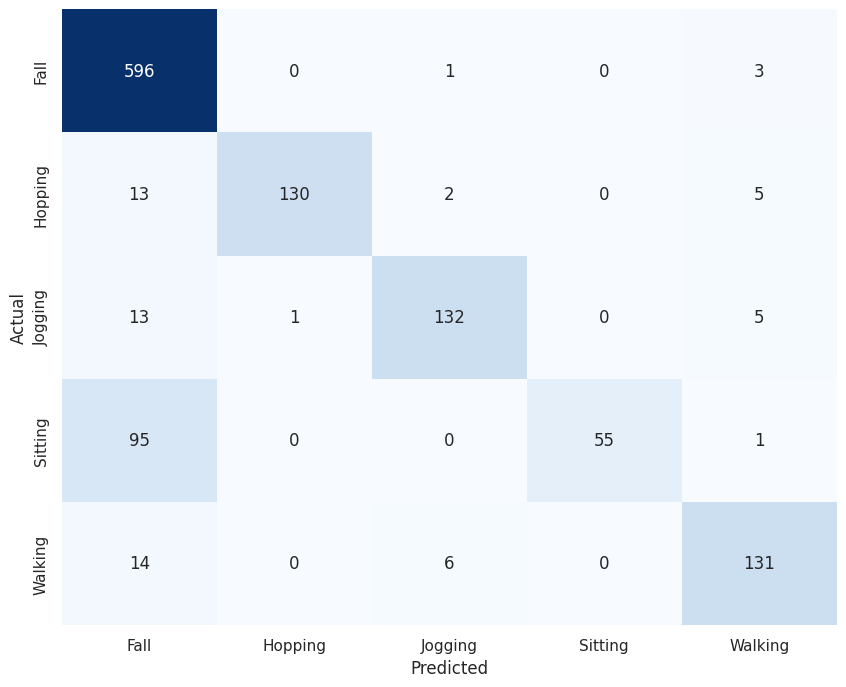

In [ ]:
f1 = []
acc = []

principal = df["user_id"].unique()

for i in principal:
    print("UTENTE: %d" % i)
    df_train = df[~(df['user_id'] == i)]
    df_test = df[df['user_id'] == i]

    # Effettua la normalizzazione dei dati
    scale_columns = ['X', 'Y', 'Z']
    scaler = RobustScaler()
    df_train[scale_columns] = scaler.fit_transform(df_train[scale_columns])
    df_test[scale_columns] = scaler.transform(df_test[scale_columns])

    # Adatta i dati per l'addestramento LSTM
    TIME_STEPS = 200
    STEP = 40
    X_train, y_train = create_dataset(df_train[['X', 'Y', 'Z']], df_train['activity'], TIME_STEPS, STEP)
    X_test, y_test = create_dataset(df_test[['X', 'Y', 'Z']], df_test['activity'], TIME_STEPS, STEP)

    # Codifica delle etichette
    enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
    enc.fit(y_train.reshape(-1, 1))
    y_train = enc.transform(y_train.reshape(-1, 1))
    y_test = enc.transform(y_test.reshape(-1, 1))

    print("Dimensione xtrain: ", X_train.shape)

    # Costruisci il modello LSTM
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.LSTM(units=64))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.Dense(units=64, activation='relu'))
    model.add(keras.layers.Dropout(rate=0.5))
    model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_m, precision_m, recall_m])

    # Addestramento del modello
    history = model.fit(X_train, y_train, batch_size=512, epochs=20, verbose=1)

    # Valutazione del modello
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    acc.append(accuracy_score(y_true, y_pred))
    f1.append(f1_score(y_true, y_pred, average='macro'))

    print(classification_report(y_true, y_pred, digits=4))

print("Media Accuracy:", np.mean(acc))
print("Media F1-score:", np.mean(f1))

rounded_labels = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Calcola la matrice di confusione
array = confusion_matrix(rounded_labels, y_pred)
classes = ["Fall", "Hopping", "Jogging", "Sitting", "Walking"]
df_cm = pd.DataFrame(array, index=classes, columns=classes)

# Imposta il font per la dimensione delle etichette
sn.set(font_scale=1)

# Visualizza la matrice di confusione come heatmap
plt.figure(figsize=(10, 8))
sn.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
model.save('/content/gdrive/MyDrive/LSTM.h5')

In [ ]:
model = load_model('/content/gdrive/MyDrive/LSTM.h5' , custom_objects={"f1_m": f1_m, "precision_m" : precision_m, "recall_m" : recall_m})

In [ ]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 200, 64)           17408     
                                                                 
 dropout_54 (Dropout)        (None, 200, 64)           0         
                                                                 
 lstm_37 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_55 (Dropout)        (None, 64)                0         
                                                                 
 dense_36 (Dense)            (None, 64)                4160      
                                                                 
 dropout_56 (Dropout)        (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 5)               

In [ ]:
def create_dataset2(X, time_steps=1, step=1):
  Xs = []
  for i in range(0, len(X)-time_steps, step):
    v = X.iloc[i: (i+time_steps)].values
    Xs.append(v)
  return np.array(Xs)

funzione a cui passo nome file csv di un utente e che da in pasto i dati dei sensori al modello per ottenere le predizioni per ogni riga

In [ ]:
def predict(file_name):
  csv = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/csv_estratti/%s' % file_name, index_col=None).drop(columns=['Unnamed: 0'])
  print(csv)
  scaler.fit(csv[scale_columns])#X,Y,Z
  csv.loc[:, scale_columns] = scaler.transform(csv[scale_columns].to_numpy())

  X_train_m = create_dataset2(csv[['X', 'Y', 'Z']], TIME_STEPS, 1)
  print("Shape di x_train_m: ", X_train_m.shape)

  return model.predict(X_train_m),  np.argmax(model.predict(X_train_m), axis=-1)

modifica il vettore ottenuto dalla predizione, da essere formato da soli numeri che indicano le classi di appartenenza, vengono tradotte nelle corrispondenti attività che dipendono dal dataset

In [ ]:
def translate(vett):
  print(vett)
  translated_vett = []

  for i in range(0,len(vett)):
    if(vett[i]==0):
      translated_vett.append('Sitting')
    elif(vett[i]==1):
      translated_vett.append('Jogging')
    elif(vett[i]==2):
      translated_vett.append('Fall')
    elif(vett[i]==3):
      translated_vett.append('Hopping')
    elif(vett[i]==4):
      translated_vett.append('Walking')

  return translated_vett

stampa una resoconto delle righe incontrate, cioè la somma di ogni colonna(attività), non è direttamente utile ai fini dell applicazione

In [ ]:
def printer(predicted_vett):
  df_activity = pd.DataFrame(predicted_vett)
  df_activity.columns=["Sitting", "Jogging", "Fall", "Hopping", "Walking"]
  print(df_activity)
  print(np.sum(df_activity['Sitting']))
  print(np.sum(df_activity['Jogging']))
  print(np.sum(df_activity['Fall']))
  print(np.sum(df_activity['Hopping']))
  print(np.sum(df_activity['Walking']))

  print(np.sum(df_activity['Sitting']+df_activity['Jogging']+df_activity['Fall']+df_activity['Hopping']+df_activity['Walking']))

questa funzione prende in input il nome del file csv e il vettore delle attività tradotto e lo inserisce in nuova colonna del file csv di partenza dell utente stesso. Questo viene poi salvato

In [ ]:
def save2(file_name, predicted_vett):
  csv = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/csv_estratti/%s' % file_name, index_col=None).drop(columns=['Unnamed: 0'])
  predicted_user = csv
  predicted_user = predicted_user.drop(predicted_user.index[len(predicted_user)-200:len(predicted_user)])

  predicted_user['PredictedActivity']=predicted_vett
  w1,w2 = file_name.split('.')
  if(not os.path.isdir('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/3C')):
    os.mkdir('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/3C')
  if(not os.path.isdir('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/3C/completi')):
    os.mkdir('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/3C/completi')
  predicted_user.to_csv('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/3C/completi/%s_Predicted.csv' % w1)
  return predicted_user

Questa funzione crea un array con tanti elementi quante sono le schermate a cui l'utente ha partecipato. in particolare ogni elemento definisce l'ultima riga del file per schermata

In [ ]:
def find_activity(predicted_user):
  interval = []
  for row in range(0,len(predicted_user)-1):
    if(predicted_user['NameActivity'].iloc[row]!=predicted_user['NameActivity'].iloc[row+1]):
      interval.append(row)
  return interval

funzione che calcola percentuali di attività svolte rispetto al totale

In [ ]:
def percentage(row, resoconto):
  falling_sum = np.sum(resoconto['Fall'])
  hopping_sum = np.sum(resoconto['Hopping'])
  jogging_sum = np.sum(resoconto['Jogging'])
  sitting_sum = np.sum(resoconto['Sitting'])
  walking_sum = np.sum(resoconto['Walking'])

  tot = falling_sum+hopping_sum+jogging_sum+sitting_sum+walking_sum

  resoconto.at[row,'NameActivity'] = 'Statistica'
  resoconto.at[row,"Sitting"] = (sitting_sum/tot)*100
  resoconto.at[row,"Jogging"] = (jogging_sum/tot)*100
  resoconto.at[row,"Fall"] = (falling_sum/tot)*100
  resoconto.at[row,"Hopping"] = (hopping_sum/tot)*100
  resoconto.at[row,"Walking"] = (walking_sum/tot)*100

crea nuova dataframe contenente tante schermate quante sono state quelle del questionario svolte e per ognuna riporta il numero di righe relative ad ogni attività

In [ ]:
def count_activities(data):
    counts = Counter(data)
    labels, values = zip(*counts.items())
    return labels, values

def calculate_reso(i, title, labels, values, resoconto):
    resoconto.at[i, 'NameActivity'] = title
    for j in range(len(labels)):
        if labels[j] in ["Fall", "Hopping", "Jogging", "Sitting", "Walking"]:
            resoconto.at[i, labels[j]] = values[j]

def total_activity(file_name, predicted_user, interval):
  resoconto = pd.DataFrame(columns = ["NameActivity","Sitting", "Jogging", "Fall", "Hopping", "Walking"])
  if(len(interval)>0):
    temp = predicted_user['PredictedActivity'].iloc[0:interval[0]].values
    title = predicted_user['NameActivity'].iloc[0]

    labels, values = count_activities(temp)

    indSort = np.argsort(values)[::-1]

    calculate_reso(0, title, labels, values, resoconto)

    i=0
    for i in range(1,len(interval)-1):
      temp = predicted_user['PredictedActivity'].iloc[interval[i]:interval[i+1]].values
      title = predicted_user['NameActivity'].iloc[interval[i]]

      labels, values = count_activities(temp)

      indSort = np.argsort(values)[::-1]

      calculate_reso(i, title, labels, values, resoconto)

    percentage(i+1, resoconto)
  else:
    temp = predicted_user['PredictedActivity'].values
    title = predicted_user['NameActivity'].iloc[0]

    labels, values = count_activities(temp)

    indSort = np.argsort(values)[::-1]

    calculate_reso(0, title, labels, values, resoconto)

    percentage(1, resoconto)

  w1,w2 = file_name.split('.')
  if(not os.path.isdir('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/3C/reso')):
    os.mkdir('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/3C/reso')
  resoconto.to_csv('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/3C/reso/%s.csv' % w1)

In [ ]:
  scale_columns = ['X', 'Y', 'Z']
  scaler = RobustScaler()
  scaler = scaler.fit(df[scale_columns])

In [ ]:
for file in os.listdir('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/csv_estratti'):
  if(not os.path.exists('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/3C/reso/%s' % file) and file.endswith('.csv')):
    print(file)
    df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/csv_estratti/%s' % file)
    if(df.shape[0]>151):
      df_predicted, predicted_vett = predict(file)
      print('\n')
      translated_vett = translate(predicted_vett)
      print('\n')
      printer(df_predicted)
      print('\n')
      predicted_user = save2(file, translated_vett)
      print('\n')
      interval_activity = find_activity(predicted_user)
      print('\n')
      total_activity(file, predicted_user, interval_activity)
      print('\n\n\n')
    else:
      print(df.shape)
      print('Troppo piccolo')
  else:
    print('File %s già creato' % file)

__sensor_1676620069247526816_ACCELEROMETER.csv
(0, 5)
Troppo piccolo
__sensor_1676620040533257101_ACCELEROMETER.csv
(0, 5)
Troppo piccolo
__sensor_1676620060184751035_ACCELEROMETER.csv
                    NameActivity         X         Y         Z
0     ['accelerometer_Video_1 '] -0.023782 -0.082177 -0.083942
1     ['accelerometer_Video_1 '] -0.020610 -0.143269 -0.082079
2     ['accelerometer_Video_1 ']  0.039311 -0.165477 -0.069307
3     ['accelerometer_Video_1 ']  0.102446 -0.087804 -0.062823
4     ['accelerometer_Video_1 ']  0.064081 -0.142030 -0.071523
...                          ...       ...       ...       ...
2094  ['accelerometer_Video_1 '] -0.031847  0.011835 -0.015784
2095  ['accelerometer_Video_1 '] -2.596635 -0.321230 -0.349574
2096  ['accelerometer_Video_1 '] -0.020987 -0.012163 -0.002312
2097  ['accelerometer_Video_1 '] -0.068492  0.002017 -0.042879
2098  ['accelerometer_Video_1 ']  0.002895 -0.021762 -0.047847

[2099 rows x 4 columns]
Shape di x_train_m:  (1899, 200, 3

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


60/60 [==============================] - 4s 69ms/step


[0 0 0 ... 2 2 2]


       Sitting   Jogging      Fall   Hopping   Walking
0     0.384055  0.026981  0.013208  0.242349  0.333408
1     0.415593  0.031203  0.013704  0.241903  0.297597
2     0.432327  0.034023  0.014263  0.240725  0.278662
3     0.431973  0.034618  0.014750  0.239636  0.279022
4     0.437805  0.035875  0.015115  0.238203  0.273003
...        ...       ...       ...       ...       ...
1894  0.000571  0.000603  0.998466  0.000010  0.000351
1895  0.000557  0.000664  0.998367  0.000011  0.000400
1896  0.000428  0.000759  0.998523  0.000009  0.000281
1897  0.000359  0.001063  0.998309  0.000008  0.000262
1898  0.000323  0.001286  0.998119  0.000008  0.000263

[1899 rows x 5 columns]
881.0995
532.96655
367.9979
28.726488
88.209465
1899.0










__sensor_1676620017580120525_ACCELEROMETER.csv
                             NameActivity         X         Y         Z
0              ['accelerometer_Video_1 '] -0.030191  0.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (57636, 200, 3)
1802/1802 [==============================] - 118s 65ms/step


[2 2 2 ... 2 2 2]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.000756  0.000742  0.998402  0.000003  0.000097
1      0.000961  0.000347  0.998612  0.000002  0.000077
2      0.001165  0.000219  0.998547  0.000002  0.000068
3      0.001329  0.000170  0.998434  0.000002  0.000064
4      0.001648  0.000232  0.998032  0.000002  0.000086
...         ...       ...       ...       ...       ...
57631  0.988270  0.002777  0.000035  0.008859  0.000060
57632  0.000909  0.001587  0.996850  0.000017  0.000637
57633  0.001048  0.001411  0.996856  0.000018  0.000667
57634  0.001281  0.001082  0.996975  0.000016  0.000646
57635  0.001571  0.000737  0.997074  0.000013  0.000604

[57636 rows x 5 columns]
5902.229
32833.125
18729.54
88.30505
82.800316
57636.0










__sensor_1676620017425216196_ACCELEROMETER.csv
                             NameActivity         X         Y         Z

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (73033, 200, 3)
2283/2283 [==============================] - 152s 67ms/step


[0 0 0 ... 0 0 0]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.994417  0.001995  0.000193  0.003342  0.000054
1      0.992502  0.003071  0.000278  0.004068  0.000081
2      0.990055  0.004561  0.000421  0.004840  0.000121
3      0.986780  0.006711  0.000567  0.005773  0.000169
4      0.983433  0.008988  0.000663  0.006696  0.000221
...         ...       ...       ...       ...       ...
73028  0.983246  0.003494  0.000053  0.013115  0.000092
73029  0.991767  0.001684  0.000025  0.006480  0.000045
73030  0.994492  0.001270  0.000023  0.004183  0.000032
73031  0.993722  0.001705  0.000041  0.004497  0.000036
73032  0.991286  0.002721  0.000076  0.005873  0.000044

[73033 rows x 5 columns]
10444.006
45545.297
15945.542
692.61676
405.5359
73033.0










__sensor_1676620014402054427_ACCELEROMETER.csv
                             NameActivity         X         Y        

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (55834, 200, 3)
1745/1745 [==============================] - 116s 66ms/step


[0 0 0 ... 2 2 2]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.956834  0.002213  0.000010  0.040920  0.000023
1      0.957169  0.002251  0.000010  0.040547  0.000022
2      0.957389  0.002222  0.000010  0.040357  0.000022
3      0.957435  0.002163  0.000010  0.040372  0.000021
4      0.958420  0.002073  0.000009  0.039479  0.000019
...         ...       ...       ...       ...       ...
55829  0.001544  0.001350  0.996456  0.000039  0.000612
55830  0.001540  0.001356  0.996447  0.000039  0.000619
55831  0.001553  0.001370  0.996405  0.000040  0.000633
55832  0.001575  0.001378  0.996361  0.000041  0.000646
55833  0.001597  0.001394  0.996298  0.000042  0.000669

[55834 rows x 5 columns]
21366.621
19127.219
10632.252
1711.4055
2996.5
55834.0










__sensor_1676620014011159764_ACCELEROMETER.csv
                             NameActivity         X         Y         Z

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (60221, 200, 3)
1882/1882 [==============================] - 126s 67ms/step


[2 2 2 ... 1 1 1]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.001297  0.000907  0.997370  0.000022  0.000404
1      0.001296  0.000925  0.997341  0.000023  0.000414
2      0.001276  0.000958  0.997323  0.000023  0.000420
3      0.001247  0.000999  0.997309  0.000023  0.000422
4      0.001238  0.001043  0.997260  0.000024  0.000434
...         ...       ...       ...       ...       ...
60216  0.000005  0.995619  0.004365  0.000009  0.000002
60217  0.000005  0.995724  0.004260  0.000009  0.000002
60218  0.000005  0.995783  0.004201  0.000008  0.000001
60219  0.000005  0.995797  0.004188  0.000008  0.000001
60220  0.000005  0.995749  0.004236  0.000009  0.000002

[60221 rows x 5 columns]
14589.9
18968.723
26393.99
165.48589
102.89979
60221.0










__sensor_1676619998240593006_ACCELEROMETER.csv
                             NameActivity         X         Y         Z

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (39197, 200, 3)
1225/1225 [==============================] - 81s 66ms/step


[1 1 1 ... 1 1 1]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.000010  0.993467  0.006512  0.000009  0.000002
1      0.000010  0.993149  0.006827  0.000011  0.000003
2      0.000009  0.993366  0.006609  0.000012  0.000003
3      0.000008  0.993763  0.006214  0.000012  0.000003
4      0.000007  0.994224  0.005755  0.000012  0.000002
...         ...       ...       ...       ...       ...
39192  0.000010  0.987244  0.012729  0.000013  0.000004
39193  0.000010  0.986195  0.013778  0.000013  0.000004
39194  0.000011  0.985296  0.014677  0.000012  0.000004
39195  0.000011  0.985457  0.014518  0.000011  0.000004
39196  0.000010  0.986875  0.013103  0.000009  0.000003

[39197 rows x 5 columns]
1399.2145
28682.559
9088.333
22.26849
4.6231694
39197.0










__sensor_1676620019950815689_ACCELEROMETER.csv
                             NameActivity         X         Y         Z

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (74432, 200, 3)
2326/2326 [==============================] - 156s 67ms/step


[2 2 2 ... 2 2 2]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.000252  0.006206  0.993296  0.000009  0.000236
1      0.000260  0.007324  0.992139  0.000012  0.000265
2      0.000236  0.008241  0.991202  0.000013  0.000307
3      0.000197  0.008205  0.991225  0.000014  0.000359
4      0.000174  0.007549  0.991844  0.000015  0.000417
...         ...       ...       ...       ...       ...
74427  0.001196  0.001097  0.997265  0.000012  0.000430
74428  0.001001  0.000941  0.997736  0.000009  0.000312
74429  0.000960  0.000849  0.997983  0.000007  0.000201
74430  0.000900  0.000800  0.998142  0.000005  0.000153
74431  0.000929  0.000795  0.998132  0.000005  0.000140

[74432 rows x 5 columns]
17472.232
37569.145
19010.496
186.628
193.4955
74432.0










__sensor_1676620025027387818_ACCELEROMETER.csv
                             NameActivity         X         Y         Z

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (69639, 200, 3)
2177/2177 [==============================] - 145s 67ms/step


[2 2 2 ... 1 1 1]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.000954  0.000480  0.998393  0.000006  0.000167
1      0.000967  0.000560  0.998258  0.000007  0.000207
2      0.001000  0.000632  0.998100  0.000010  0.000259
3      0.001039  0.000673  0.997945  0.000012  0.000331
4      0.001108  0.000686  0.997776  0.000014  0.000416
...         ...       ...       ...       ...       ...
69634  0.000010  0.993528  0.006449  0.000010  0.000003
69635  0.000008  0.994267  0.005713  0.000009  0.000003
69636  0.000007  0.994735  0.005246  0.000009  0.000002
69637  0.000006  0.994959  0.005023  0.000009  0.000002
69638  0.000006  0.995049  0.004934  0.000009  0.000002

[69639 rows x 5 columns]
10486.874
36188.723
22606.102
159.10948
198.19295
69639.0










__sensor_1676620036470540022_ACCELEROMETER.csv
                             NameActivity         X         Y       

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (68591, 200, 3)
2144/2144 [==============================] - 145s 67ms/step


[0 0 0 ... 1 1 1]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.954757  0.008365  0.000052  0.036755  0.000071
1      0.956091  0.008801  0.000055  0.034981  0.000071
2      0.957831  0.009080  0.000058  0.032960  0.000072
3      0.959667  0.009237  0.000059  0.030965  0.000072
4      0.961361  0.009421  0.000062  0.029082  0.000074
...         ...       ...       ...       ...       ...
68586  0.000006  0.993790  0.006193  0.000008  0.000002
68587  0.000007  0.993479  0.006504  0.000008  0.000003
68588  0.000006  0.993878  0.006106  0.000007  0.000002
68589  0.000005  0.994474  0.005512  0.000007  0.000002
68590  0.000005  0.994952  0.005034  0.000006  0.000002

[68591 rows x 5 columns]
25823.121
20087.395
16705.008
5397.608
577.8655
68591.0










__sensor_1676620042634779389_ACCELEROMETER.csv
                             NameActivity         X         Y         

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (48103, 200, 3)
1504/1504 [==============================] - 101s 67ms/step


[0 0 0 ... 2 2 2]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.985148  0.000019  0.014753  0.000017  0.000063
1      0.985780  0.000019  0.014122  0.000019  0.000060
2      0.984415  0.000022  0.015477  0.000022  0.000065
3      0.981975  0.000026  0.017898  0.000027  0.000074
4      0.976837  0.000033  0.022999  0.000037  0.000093
...         ...       ...       ...       ...       ...
48098  0.000724  0.000537  0.998610  0.000005  0.000123
48099  0.997032  0.000680  0.000017  0.002261  0.000010
48100  0.000833  0.000365  0.998732  0.000003  0.000068
48101  0.000814  0.000369  0.998752  0.000003  0.000062
48102  0.000732  0.000408  0.998787  0.000003  0.000070

[48103 rows x 5 columns]
11642.404
21406.246
14163.367
253.75789
637.2257
48103.0










__sensor_1676620044960300264_ACCELEROMETER.csv
                             NameActivity         X         Y        

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (75073, 200, 3)
2347/2347 [==============================] - 159s 68ms/step


[2 2 2 ... 2 2 2]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.011092  0.018397  0.924782  0.001134  0.044594
1      0.004346  0.011700  0.971543  0.000245  0.012166
2      0.001959  0.008001  0.985669  0.000071  0.004299
3      0.984760  0.005560  0.000062  0.009591  0.000027
4      0.985467  0.004401  0.000042  0.010064  0.000027
...         ...       ...       ...       ...       ...
75068  0.989835  0.000664  0.000005  0.009488  0.000008
75069  0.000657  0.000898  0.997917  0.000012  0.000515
75070  0.000555  0.000964  0.998181  0.000007  0.000293
75071  0.001199  0.001541  0.996888  0.000009  0.000362
75072  0.000363  0.001118  0.998423  0.000003  0.000093

[75073 rows x 5 columns]
19954.156
32635.299
21089.264
518.62604
875.6497
75073.0










__sensor_1676620046493491632_ACCELEROMETER.csv
                             NameActivity         X         Y        

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (71550, 200, 3)
2236/2236 [==============================] - 152s 68ms/step


[1 1 1 ... 0 0 0]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.000013  0.991069  0.008897  0.000017  0.000005
1      0.000011  0.991697  0.008271  0.000016  0.000004
2      0.000010  0.992551  0.007421  0.000014  0.000004
3      0.000008  0.993251  0.006724  0.000013  0.000003
4      0.000007  0.993849  0.006128  0.000012  0.000003
...         ...       ...       ...       ...       ...
71545  0.997499  0.000402  0.000014  0.002069  0.000015
71546  0.997617  0.000332  0.000013  0.002022  0.000015
71547  0.997914  0.000250  0.000012  0.001814  0.000011
71548  0.998326  0.000182  0.000012  0.001473  0.000008
71549  0.997958  0.000226  0.000011  0.001796  0.000009

[71550 rows x 5 columns]
14968.982
33677.484
21869.898
310.4614
723.1762
71550.0










__sensor_1676620049465375119_ACCELEROMETER.csv
                             NameActivity         X         Y         

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (50159, 200, 3)
1568/1568 [==============================] - 109s 70ms/step


[1 1 1 ... 2 2 2]


        Sitting   Jogging      Fall   Hopping       Walking
0      0.000003  0.996784  0.003209  0.000004  7.174434e-07
1      0.000003  0.996713  0.003279  0.000004  7.702676e-07
2      0.000003  0.996646  0.003346  0.000004  8.286005e-07
3      0.000003  0.996588  0.003404  0.000005  8.853078e-07
4      0.000003  0.996535  0.003456  0.000005  9.316912e-07
...         ...       ...       ...       ...           ...
50154  0.004362  0.003630  0.991442  0.000055  5.122049e-04
50155  0.003950  0.003336  0.992141  0.000054  5.191211e-04
50156  0.003564  0.003047  0.992798  0.000052  5.388119e-04
50157  0.003189  0.002700  0.993496  0.000049  5.666659e-04
50158  0.002890  0.002301  0.994188  0.000044  5.770084e-04

[50159 rows x 5 columns]
6657.0474
29612.225
13683.241
88.04413
118.440285
50159.0










__sensor_1676620051331887109_ACCELEROMETER.csv
                    

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (71723, 200, 3)
2242/2242 [==============================] - 154s 69ms/step


[1 1 1 ... 0 0 0]


        Sitting   Jogging      Fall   Hopping       Walking
0      0.000003  0.997053  0.002938  0.000005  8.353147e-07
1      0.000003  0.996954  0.003037  0.000005  8.788948e-07
2      0.000003  0.996848  0.003143  0.000005  9.261493e-07
3      0.000003  0.996744  0.003246  0.000005  9.757216e-07
4      0.000003  0.996639  0.003351  0.000006  1.023246e-06
...         ...       ...       ...       ...           ...
71718  0.971461  0.005929  0.000037  0.022504  6.911051e-05
71719  0.970056  0.006191  0.000038  0.023638  7.673760e-05
71720  0.968371  0.006482  0.000039  0.025029  7.922573e-05
71721  0.967496  0.006568  0.000039  0.025812  8.501609e-05
71722  0.966471  0.006656  0.000039  0.026747  8.637043e-05

[71723 rows x 5 columns]
15597.694
37884.086
17821.527
261.72516
157.96838
71723.0










__sensor_1676620055015635553_ACCELEROMETER.csv
                    

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (20412, 200, 3)
638/638 [==============================] - 43s 68ms/step


[0 0 0 ... 0 0 0]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.959172  0.016842  0.000235  0.023459  0.000292
1      0.945108  0.028227  0.000392  0.025989  0.000284
2      0.934712  0.037954  0.000467  0.026634  0.000233
3      0.930060  0.041319  0.000435  0.027996  0.000190
4      0.933614  0.036041  0.000325  0.029876  0.000144
...         ...       ...       ...       ...       ...
20407  0.965384  0.008092  0.000144  0.026105  0.000275
20408  0.964776  0.008035  0.000135  0.026784  0.000270
20409  0.969289  0.005511  0.000097  0.024924  0.000180
20410  0.969849  0.006560  0.000083  0.023349  0.000159
20411  0.967337  0.007454  0.000078  0.024968  0.000162

[20412 rows x 5 columns]
3910.8613
9277.387
6794.04
135.90147
293.80984
20412.0










__sensor_1676620064171954470_ACCELEROMETER.csv
                             NameActivity         X         Y         Z
0 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (39853, 200, 3)
1246/1246 [==============================] - 84s 68ms/step


[2 2 2 ... 0 0 0]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.001493  0.000095  0.998383  0.000001  0.000028
1      0.001297  0.000118  0.998555  0.000001  0.000029
2      0.001054  0.000163  0.998749  0.000001  0.000033
3      0.000984  0.000220  0.998759  0.000002  0.000035
4      0.000823  0.000312  0.998821  0.000002  0.000042
...         ...       ...       ...       ...       ...
39848  0.997199  0.000191  0.000004  0.002602  0.000004
39849  0.997683  0.000161  0.000004  0.002149  0.000003
39850  0.997839  0.000142  0.000004  0.002012  0.000003
39851  0.998627  0.000090  0.000004  0.001277  0.000002
39852  0.999147  0.000058  0.000003  0.000791  0.000001

[39853 rows x 5 columns]
5988.722
20262.768
13484.223
79.63743
37.650166
39853.0










__sensor_1676620072373727560_ACCELEROMETER.csv
(0, 5)
Troppo piccolo
__sensor_1676620071462856086_ACCELEROMETER.csv
  

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (31152, 200, 3)
974/974 [==============================] - 66s 68ms/step


[1 1 1 ... 1 1 1]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.000007  0.991123  0.008853  0.000013  0.000004
1      0.000007  0.991857  0.008121  0.000012  0.000003
2      0.000006  0.992607  0.007373  0.000011  0.000003
3      0.000006  0.993323  0.006660  0.000009  0.000002
4      0.000005  0.993932  0.006053  0.000008  0.000002
...         ...       ...       ...       ...       ...
31147  0.000004  0.995392  0.004595  0.000008  0.000001
31148  0.000004  0.995299  0.004688  0.000008  0.000002
31149  0.000004  0.995106  0.004879  0.000009  0.000002
31150  0.000004  0.994856  0.005127  0.000011  0.000002
31151  0.000005  0.994571  0.005410  0.000012  0.000002

[31152 rows x 5 columns]
6665.09
15119.211
9100.74
104.75823
162.20074
31152.0










__sensor_1676620083356611563_ACCELEROMETER.csv
                    NameActivity         X         Y         Z
0     ['acce

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


74/74 [==============================] - 5s 68ms/step


[0 2 2 ... 0 0 0]


       Sitting   Jogging      Fall   Hopping   Walking
0     0.996813  0.000747  0.000053  0.002374  0.000014
1     0.000358  0.000729  0.998866  0.000003  0.000044
2     0.000263  0.001046  0.998622  0.000004  0.000065
3     0.000184  0.001415  0.998309  0.000005  0.000087
4     0.000145  0.001784  0.997950  0.000005  0.000115
...        ...       ...       ...       ...       ...
2345  0.920177  0.000253  0.079093  0.000194  0.000283
2346  0.971399  0.000202  0.028012  0.000198  0.000190
2347  0.989786  0.000177  0.009729  0.000201  0.000107
2348  0.995894  0.000144  0.003693  0.000205  0.000065
2349  0.997178  0.000175  0.002237  0.000327  0.000084

[2350 rows x 5 columns]
276.16995
1027.2297
1042.2224
3.3436913
1.0341609
2350.0










__sensor_1676620092377040559_ACCELEROMETER.csv
                             NameActivity         X         Y         Z
0              ['accelerometer_Video_1 ']  0.011743 -

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (50630, 200, 3)
1583/1583 [==============================] - 108s 68ms/step


[0 0 0 ... 1 1 1]


        Sitting   Jogging      Fall   Hopping       Walking
0      0.968388  0.007529  0.000258  0.022535  1.289414e-03
1      0.970376  0.006942  0.000208  0.021478  9.969143e-04
2      0.971854  0.006441  0.000170  0.020712  8.226631e-04
3      0.973142  0.006053  0.000143  0.019971  6.912492e-04
4      0.973820  0.005860  0.000126  0.019569  6.248790e-04
...         ...       ...       ...       ...           ...
50625  0.000003  0.996637  0.003354  0.000005  9.124244e-07
50626  0.000003  0.996601  0.003390  0.000005  9.170132e-07
50627  0.000003  0.996520  0.003471  0.000005  9.205713e-07
50628  0.000003  0.996431  0.003559  0.000005  9.492537e-07
50629  0.000003  0.996351  0.003639  0.000005  1.000217e-06

[50630 rows x 5 columns]
5843.3647
22902.455
21715.566
70.0174
98.59384
50630.0










__sensor_1676620094376210391_ACCELEROMETER.csv
                       

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (51755, 200, 3)
1618/1618 [==============================] - 110s 68ms/step


[4 4 2 ... 1 1 1]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.039036  0.008355  0.071955  0.013357  0.867299
1      0.038877  0.008293  0.069081  0.013806  0.869944
2      0.003113  0.005325  0.980313  0.000135  0.011113
3      0.002877  0.006478  0.980459  0.000139  0.010048
4      0.039358  0.008777  0.067301  0.014395  0.870170
...         ...       ...       ...       ...       ...
51750  0.000143  0.907079  0.092605  0.000086  0.000088
51751  0.000123  0.920281  0.079443  0.000081  0.000072
51752  0.000047  0.965350  0.034521  0.000058  0.000024
51753  0.000085  0.941564  0.058238  0.000068  0.000046
51754  0.000018  0.986001  0.013942  0.000031  0.000008

[51755 rows x 5 columns]
25063.758
19227.887
5958.648
252.48087
1252.2263
51755.0










__sensor_1676620094844484546_ACCELEROMETER.csv
                             NameActivity         X         Y        

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (57838, 200, 3)
1808/1808 [==============================] - 126s 70ms/step


[1 1 1 ... 0 0 0]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.000009  0.995050  0.004934  0.000005  0.000002
1      0.000008  0.995120  0.004865  0.000005  0.000002
2      0.000007  0.995135  0.004851  0.000005  0.000002
3      0.000006  0.995006  0.004980  0.000006  0.000002
4      0.000006  0.994977  0.005009  0.000006  0.000002
...         ...       ...       ...       ...       ...
57833  0.988400  0.002438  0.000012  0.009136  0.000014
57834  0.988903  0.002283  0.000011  0.008792  0.000011
57835  0.989983  0.002155  0.000010  0.007844  0.000009
57836  0.991077  0.001904  0.000009  0.007003  0.000007
57837  0.991895  0.001677  0.000008  0.006413  0.000007

[57838 rows x 5 columns]
10891.969
29962.158
16631.896
167.34755
184.62985
57838.0










__sensor_1676620095848200935_ACCELEROMETER.csv
(0, 5)
Troppo piccolo
__sensor_1676620101901194421_ACCELEROMETER.csv

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (27830, 200, 3)
870/870 [==============================] - 59s 68ms/step


[1 1 1 ... 1 1 1]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.000058  0.909792  0.090085  0.000038  0.000026
1      0.000056  0.913325  0.086553  0.000039  0.000026
2      0.000056  0.915018  0.084860  0.000040  0.000026
3      0.000055  0.917171  0.082708  0.000040  0.000026
4      0.000055  0.919262  0.080616  0.000041  0.000026
...         ...       ...       ...       ...       ...
27825  0.000005  0.994190  0.005796  0.000007  0.000002
27826  0.000005  0.994186  0.005800  0.000007  0.000002
27827  0.000005  0.994023  0.005962  0.000008  0.000002
27828  0.000004  0.994418  0.005569  0.000007  0.000002
27829  0.000005  0.994201  0.005785  0.000007  0.000002

[27830 rows x 5 columns]
1034.9089
16875.363
9890.614
19.83421
9.27784
27830.0










__sensor_1676620107332795302_ACCELEROMETER.csv
                             NameActivity         X         Y         Z
0  

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (68076, 200, 3)
2128/2128 [==============================] - 147s 69ms/step


[1 1 1 ... 1 1 1]


        Sitting   Jogging      Fall   Hopping       Walking
0      0.000003  0.996762  0.003230  0.000004  8.239302e-07
1      0.000003  0.996761  0.003232  0.000004  8.361885e-07
2      0.000003  0.996759  0.003233  0.000004  8.455037e-07
3      0.000003  0.996758  0.003234  0.000004  8.483878e-07
4      0.000003  0.996750  0.003241  0.000004  8.523485e-07
...         ...       ...       ...       ...           ...
68071  0.000003  0.996682  0.003308  0.000005  9.926895e-07
68072  0.000003  0.996622  0.003368  0.000006  1.007429e-06
68073  0.000003  0.996585  0.003405  0.000006  1.023603e-06
68074  0.000003  0.996566  0.003424  0.000006  1.035595e-06
68075  0.000003  0.996587  0.003403  0.000005  1.018922e-06

[68076 rows x 5 columns]
6593.3887
47753.586
13594.1875
116.78621
18.049786
68076.0










__sensor_1676620107767131933_ACCELEROMETER.csv
                   

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (24768, 200, 3)
774/774 [==============================] - 52s 67ms/step


[2 2 2 ... 1 1 1]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.001769  0.001840  0.995910  0.000045  0.000436
1      0.001769  0.002009  0.995717  0.000050  0.000455
2      0.001765  0.002131  0.995580  0.000054  0.000469
3      0.001737  0.002180  0.995556  0.000056  0.000471
4      0.001750  0.002176  0.995546  0.000057  0.000472
...         ...       ...       ...       ...       ...
24763  0.000005  0.995486  0.004501  0.000007  0.000001
24764  0.000005  0.995528  0.004459  0.000006  0.000001
24765  0.000005  0.995461  0.004525  0.000007  0.000002
24766  0.000005  0.995461  0.004526  0.000007  0.000002
24767  0.000005  0.995462  0.004524  0.000008  0.000002

[24768 rows x 5 columns]
1064.4071
17444.404
6209.2983
23.52365
26.366512
24768.0










__sensor_1676620114697630240_ACCELEROMETER.csv
                             NameActivity         X         Y         Z


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (68924, 200, 3)
2154/2154 [==============================] - 148s 69ms/step


[2 2 2 ... 1 1 1]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.001164  0.000793  0.997712  0.000015  0.000316
1      0.001157  0.000858  0.997628  0.000017  0.000341
2      0.001171  0.000910  0.997541  0.000019  0.000359
3      0.001161  0.000956  0.997492  0.000020  0.000370
4      0.001166  0.001017  0.997442  0.000022  0.000354
...         ...       ...       ...       ...       ...
68919  0.000040  0.949208  0.050688  0.000040  0.000023
68920  0.000040  0.949294  0.050604  0.000040  0.000023
68921  0.000039  0.950050  0.049846  0.000041  0.000024
68922  0.000045  0.945340  0.054543  0.000047  0.000025
68923  0.000050  0.938596  0.061283  0.000046  0.000025

[68924 rows x 5 columns]
6136.0376
43056.785
19591.049
92.18182
47.944508
68924.0










__sensor_1676620253190373288_ACCELEROMETER.csv
(0, 5)
Troppo piccolo
__sensor_1676620157590622809_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (69893, 200, 3)
2185/2185 [==============================] - 151s 69ms/step


[2 2 2 ... 2 2 2]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.000535  0.000941  0.998255  0.000009  0.000261
1      0.000525  0.001085  0.998083  0.000010  0.000298
2      0.000463  0.001336  0.997878  0.000010  0.000312
3      0.000388  0.001735  0.997550  0.000012  0.000315
4      0.000323  0.002223  0.997116  0.000014  0.000323
...         ...       ...       ...       ...       ...
69888  0.001028  0.055151  0.943431  0.000079  0.000312
69889  0.000981  0.048171  0.950429  0.000076  0.000343
69890  0.001017  0.033485  0.965062  0.000070  0.000365
69891  0.001013  0.022351  0.976211  0.000060  0.000366
69892  0.000982  0.016799  0.981793  0.000053  0.000374

[69893 rows x 5 columns]
19093.23
30760.188
18961.01
698.7698
379.79956
69893.0










__sensor_1676620317895938215_ACCELEROMETER.csv
                            NameActivity         X         Y         Z


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


211/211 [==============================] - 15s 69ms/step


[2 2 2 ... 2 2 2]


       Sitting   Jogging      Fall   Hopping   Walking
0     0.002013  0.001175  0.993356  0.000038  0.003418
1     0.002252  0.001132  0.992968  0.000038  0.003611
2     0.001177  0.001148  0.994595  0.000034  0.003046
3     0.001052  0.001416  0.994562  0.000039  0.002930
4     0.000889  0.001472  0.994671  0.000039  0.002929
...        ...       ...       ...       ...       ...
6729  0.001647  0.012655  0.980409  0.000158  0.005131
6730  0.001429  0.013119  0.982137  0.000095  0.003220
6731  0.001077  0.012899  0.983705  0.000060  0.002259
6732  0.000877  0.016397  0.981159  0.000043  0.001525
6733  0.000722  0.022450  0.975760  0.000032  0.001037

[6734 rows x 5 columns]
758.9927
3612.9165
2306.3274
22.529697
33.233658
6734.0










__sensor_1676620977756108043_ACCELEROMETER.csv
                             NameActivity         X         Y         Z
0              ['accelerometer_Video_1 ']  0.114091

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (27127, 200, 3)
848/848 [==============================] - 58s 69ms/step


[0 0 0 ... 1 1 1]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.999281  0.000032  0.000004  0.000682  0.000001
1      0.999321  0.000031  0.000004  0.000643  0.000001
2      0.999324  0.000031  0.000004  0.000640  0.000001
3      0.999329  0.000031  0.000004  0.000635  0.000001
4      0.999308  0.000031  0.000004  0.000656  0.000001
...         ...       ...       ...       ...       ...
27122  0.000015  0.980016  0.019942  0.000018  0.000009
27123  0.000011  0.985085  0.014882  0.000015  0.000006
27124  0.000009  0.988619  0.011356  0.000012  0.000005
27125  0.000007  0.990996  0.008983  0.000010  0.000003
27126  0.000006  0.992568  0.007415  0.000009  0.000003

[27127 rows x 5 columns]
1570.5585
21504.379
4023.896
16.498848
11.666597
27127.0










__sensor_1676621281704491638_ACCELEROMETER.csv
(68, 5)
Troppo piccolo
__sensor_1676621485506657854_ACCELEROMETER.csv
  

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (77518, 200, 3)
2423/2423 [==============================] - 165s 68ms/step


[2 2 2 ... 1 1 1]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.000425  0.346754  0.652638  0.000068  0.000115
1      0.000460  0.340203  0.659160  0.000059  0.000118
2      0.000491  0.441331  0.558020  0.000050  0.000108
3      0.000530  0.560457  0.438849  0.000049  0.000114
4      0.000595  0.670886  0.328318  0.000058  0.000143
...         ...       ...       ...       ...       ...
77513  0.000015  0.981773  0.018186  0.000019  0.000008
77514  0.000012  0.985502  0.014464  0.000016  0.000006
77515  0.000009  0.988829  0.011143  0.000014  0.000005
77516  0.000008  0.990684  0.009293  0.000012  0.000004
77517  0.000007  0.991938  0.008042  0.000011  0.000003

[77518 rows x 5 columns]
12127.535
51492.16
13760.918
119.560036
17.831055
77518.0










__sensor_1676621550339829073_ACCELEROMETER.csv
                             NameActivity         X         Y       

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (98615, 200, 3)
3082/3082 [==============================] - 213s 69ms/step


[4 4 4 ... 0 0 0]


        Sitting   Jogging          Fall   Hopping       Walking
0      0.029298  0.012474  1.462254e-01  0.016640  7.953623e-01
1      0.031274  0.014594  1.855894e-01  0.015358  7.531850e-01
2      0.032631  0.016721  2.224206e-01  0.014993  7.132338e-01
3      0.032287  0.016840  2.340043e-01  0.015101  7.017679e-01
4      0.029846  0.015100  2.268666e-01  0.016347  7.118409e-01
...         ...       ...           ...       ...           ...
98610  0.999809  0.000047  7.999662e-07  0.000143  2.867179e-07
98611  0.999751  0.000059  1.472608e-06  0.000188  5.489542e-07
98612  0.999811  0.000062  3.061551e-06  0.000124  5.394351e-07
98613  0.999708  0.000108  6.174575e-06  0.000177  7.423442e-07
98614  0.999673  0.000132  6.357445e-06  0.000187  7.722967e-07

[98615 rows x 5 columns]
26638.525
46455.6
20671.549
304.7132
4544.604
98615.0










__sensor_16766308382179

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (73819, 200, 3)
2307/2307 [==============================] - 158s 69ms/step


[0 0 0 ... 1 1 1]


        Sitting   Jogging      Fall   Hopping       Walking
0      0.999269  0.000065  0.000004  0.000661  1.484844e-06
1      0.998722  0.000100  0.000004  0.001172  1.990953e-06
2      0.998047  0.000126  0.000003  0.001822  1.916196e-06
3      0.997134  0.000167  0.000002  0.002695  1.761045e-06
4      0.995522  0.000258  0.000002  0.004215  1.933352e-06
...         ...       ...       ...       ...           ...
73814  0.000003  0.996419  0.003571  0.000005  9.688696e-07
73815  0.000003  0.996458  0.003533  0.000005  9.307935e-07
73816  0.000003  0.996454  0.003537  0.000005  9.304922e-07
73817  0.000003  0.996441  0.003550  0.000005  9.549792e-07
73818  0.000003  0.996420  0.003571  0.000005  9.975405e-07

[73819 rows x 5 columns]
19706.668
22455.814
28461.924
1994.6805
1199.907
73819.0










__sensor_1676630838663641248_ACCELEROMETER.csv
                     

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (69408, 200, 3)
2169/2169 [==============================] - 150s 69ms/step


[0 0 0 ... 1 1 0]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.984763  0.002028  0.000011  0.013188  0.000011
1      0.985599  0.001922  0.000010  0.012459  0.000010
2      0.986118  0.001853  0.000010  0.012011  0.000009
3      0.986323  0.001744  0.000009  0.011915  0.000008
4      0.987373  0.001684  0.000009  0.010926  0.000008
...         ...       ...       ...       ...       ...
69403  0.000003  0.996309  0.003681  0.000005  0.000001
69404  0.000003  0.996316  0.003673  0.000006  0.000001
69405  0.000004  0.996375  0.003615  0.000006  0.000001
69406  0.000004  0.996413  0.003576  0.000006  0.000001
69407  0.989132  0.001902  0.000007  0.008945  0.000013

[69408 rows x 5 columns]
16516.191
29070.48
18765.424
1659.9021
3396.0012
69408.0










__sensor_1676630848094489204_ACCELEROMETER.csv
                             NameActivity         X         Y        

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (85489, 200, 3)
2672/2672 [==============================] - 182s 68ms/step


[2 2 2 ... 1 1 1]


        Sitting   Jogging      Fall   Hopping       Walking
0      0.000252  0.005482  0.994072  0.000007  1.869723e-04
1      0.000258  0.005138  0.994428  0.000006  1.703844e-04
2      0.000262  0.004732  0.994841  0.000006  1.591105e-04
3      0.000258  0.004622  0.994954  0.000006  1.598474e-04
4      0.000255  0.004816  0.994751  0.000006  1.717941e-04
...         ...       ...       ...       ...           ...
85484  0.000004  0.994269  0.005721  0.000004  9.792533e-07
85485  0.000007  0.990760  0.009226  0.000005  1.512334e-06
85486  0.000013  0.982291  0.017684  0.000009  3.548250e-06
85487  0.000033  0.953230  0.046707  0.000018  1.125169e-05
85488  0.000054  0.915247  0.084657  0.000023  1.864749e-05

[85489 rows x 5 columns]
9216.165
49147.63
26947.107
107.30109
70.7984
85489.0










__sensor_1676630850915133315_ACCELEROMETER.csv
                        

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (79619, 200, 3)
2489/2489 [==============================] - 170s 68ms/step


[1 1 1 ... 0 0 0]


        Sitting   Jogging      Fall   Hopping       Walking
0      0.000002  0.996808  0.003186  0.000003  6.884415e-07
1      0.000002  0.996922  0.003072  0.000003  6.772567e-07
2      0.000002  0.996928  0.003067  0.000003  7.032486e-07
3      0.000002  0.996870  0.003123  0.000003  7.535629e-07
4      0.000002  0.996792  0.003201  0.000003  8.132110e-07
...         ...       ...       ...       ...           ...
79614  0.001150  0.000459  0.998049  0.000006  3.352205e-04
79615  0.997758  0.000473  0.000038  0.001710  2.030607e-05
79616  0.996777  0.000628  0.000034  0.002540  2.176119e-05
79617  0.994868  0.000999  0.000031  0.004072  2.964300e-05
79618  0.992070  0.001666  0.000033  0.006182  5.003914e-05

[79619 rows x 5 columns]
4705.882
54129.965
20695.531
63.957863
23.660795
79619.0










__sensor_1676630851743014474_ACCELEROMETER.csv
                     

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (62734, 200, 3)
1961/1961 [==============================] - 134s 68ms/step


[2 2 2 ... 2 2 2]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.000660  0.002228  0.996381  0.000010  0.000722
1      0.000878  0.004834  0.993730  0.000010  0.000549
2      0.000892  0.010674  0.988028  0.000009  0.000397
3      0.000847  0.027171  0.971703  0.000010  0.000269
4      0.000702  0.059745  0.939375  0.000010  0.000168
...         ...       ...       ...       ...       ...
62729  0.000293  0.011803  0.987400  0.000026  0.000478
62730  0.000308  0.012148  0.987068  0.000026  0.000450
62731  0.000301  0.012416  0.986807  0.000025  0.000451
62732  0.000281  0.011860  0.987352  0.000026  0.000481
62733  0.000276  0.011557  0.987611  0.000027  0.000529

[62734 rows x 5 columns]
5176.015
43845.664
13640.555
62.579933
9.18677
62734.0










__sensor_1676630853043505728_ACCELEROMETER.csv
                             NameActivity         X         Y         Z

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (64083, 200, 3)
2003/2003 [==============================] - 138s 69ms/step


[2 2 2 ... 2 2 2]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.000325  0.004015  0.995225  0.000016  0.000419
1      0.000277  0.005425  0.993937  0.000014  0.000346
2      0.000249  0.007871  0.991551  0.000013  0.000316
3      0.000231  0.011071  0.988377  0.000014  0.000307
4      0.000229  0.014377  0.985050  0.000015  0.000329
...         ...       ...       ...       ...       ...
64078  0.000908  0.000848  0.998047  0.000010  0.000187
64079  0.000991  0.000686  0.998150  0.000009  0.000164
64080  0.001103  0.000525  0.998232  0.000008  0.000132
64081  0.001154  0.000408  0.998321  0.000007  0.000111
64082  0.001123  0.000375  0.998386  0.000006  0.000111

[64083 rows x 5 columns]
9331.163
32233.223
21955.652
184.64278
378.31943
64083.0










__sensor_1676630854509622963_ACCELEROMETER.csv
(0, 5)
Troppo piccolo
__sensor_1676630854251354901_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (63151, 200, 3)
1974/1974 [==============================] - 131s 66ms/step


[0 0 0 ... 1 1 1]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.988955  0.002542  0.000097  0.008126  0.000280
1      0.989900  0.002307  0.000086  0.007438  0.000269
2      0.991061  0.002011  0.000073  0.006607  0.000247
3      0.992824  0.001620  0.000054  0.005326  0.000176
4      0.993716  0.001484  0.000046  0.004607  0.000147
...         ...       ...       ...       ...       ...
63146  0.000004  0.994772  0.005217  0.000005  0.000001
63147  0.000005  0.994347  0.005642  0.000005  0.000001
63148  0.000005  0.994336  0.005654  0.000004  0.000001
63149  0.000004  0.994699  0.005292  0.000004  0.000001
63150  0.000004  0.995022  0.004969  0.000004  0.000001

[63151 rows x 5 columns]
12130.741
32020.02
18190.305
450.7976
359.1356
63151.0










__sensor_1676630855816334862_ACCELEROMETER.csv
                             NameActivity         X         Y         Z

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (68962, 200, 3)
2156/2156 [==============================] - 141s 65ms/step


[2 2 2 ... 1 1 1]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.001098  0.073651  0.924927  0.000190  0.000134
1      0.001305  0.033668  0.964760  0.000145  0.000123
2      0.001478  0.012989  0.985331  0.000094  0.000109
3      0.001534  0.005275  0.993038  0.000056  0.000097
4      0.001546  0.002930  0.995387  0.000040  0.000097
...         ...       ...       ...       ...       ...
68957  0.000006  0.990913  0.009076  0.000003  0.000001
68958  0.000006  0.990815  0.009174  0.000004  0.000001
68959  0.000005  0.990886  0.009103  0.000004  0.000002
68960  0.000005  0.991529  0.008461  0.000004  0.000002
68961  0.000004  0.992740  0.007251  0.000003  0.000001

[68962 rows x 5 columns]
13366.05
37161.434
18163.957
178.9228
91.63965
68962.0










__sensor_1676630856607027739_ACCELEROMETER.csv
                             NameActivity         X         Y         Z

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (82607, 200, 3)
2582/2582 [==============================] - 178s 69ms/step


[0 0 0 ... 0 0 0]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.996221  0.000918  0.000016  0.002822  0.000023
1      0.996633  0.000840  0.000014  0.002493  0.000019
2      0.996464  0.000893  0.000014  0.002612  0.000018
3      0.996290  0.000924  0.000014  0.002755  0.000017
4      0.996523  0.000850  0.000012  0.002600  0.000015
...         ...       ...       ...       ...       ...
82602  0.976471  0.005624  0.000111  0.017186  0.000608
82603  0.986569  0.003845  0.000084  0.009202  0.000299
82604  0.993877  0.001721  0.000058  0.004228  0.000116
82605  0.995591  0.001137  0.000055  0.003146  0.000071
82606  0.994525  0.001045  0.000044  0.004340  0.000047

[82607 rows x 5 columns]
22939.412
32804.957
24924.047
266.30273
1672.2864
82607.0










__sensor_1676630857494712403_ACCELEROMETER.csv
                             NameActivity         X         Y       

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (78506, 200, 3)
2454/2454 [==============================] - 171s 70ms/step


[2 2 2 ... 0 0 0]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.000905  0.002475  0.991630  0.000076  0.004914
1      0.001000  0.002214  0.991968  0.000072  0.004746
2      0.001063  0.002104  0.992088  0.000070  0.004676
3      0.001153  0.002044  0.991779  0.000073  0.004951
4      0.001210  0.002010  0.991238  0.000079  0.005462
...         ...       ...       ...       ...       ...
78501  0.997446  0.000423  0.000004  0.002124  0.000003
78502  0.998040  0.000350  0.000005  0.001601  0.000003
78503  0.998566  0.000288  0.000006  0.001137  0.000003
78504  0.998873  0.000221  0.000007  0.000896  0.000003
78505  0.999013  0.000187  0.000007  0.000789  0.000003

[78506 rows x 5 columns]
19691.975
36896.15
20528.438
629.35583
760.0816
78506.0










__sensor_1676630858689486708_ACCELEROMETER.csv
                             NameActivity         X         Y         

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (94238, 200, 3)
2945/2945 [==============================] - 202s 69ms/step


[0 0 0 ... 0 0 0]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.990011  0.001673  0.000017  0.008283  0.000016
1      0.995520  0.001049  0.000020  0.003401  0.000009
2      0.996885  0.000876  0.000017  0.002214  0.000008
3      0.998309  0.000624  0.000022  0.001040  0.000005
4      0.998976  0.000402  0.000024  0.000594  0.000004
...         ...       ...       ...       ...       ...
94233  0.962810  0.001609  0.000007  0.035563  0.000011
94234  0.957081  0.001551  0.000007  0.041350  0.000011
94235  0.951298  0.001645  0.000008  0.047039  0.000011
94236  0.953466  0.001923  0.000010  0.044589  0.000012
94237  0.952467  0.002288  0.000012  0.045220  0.000013

[94238 rows x 5 columns]
22943.889
47510.605
13304.21
10179.344
299.94794
94238.0










__sensor_1676630860854418392_ACCELEROMETER.csv
                             NameActivity         X         Y        

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (67504, 200, 3)
2110/2110 [==============================] - 148s 70ms/step


[0 0 0 ... 1 1 1]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.997972  0.000195  0.000008  0.001817  0.000008
1      0.997753  0.000205  0.000008  0.002026  0.000008
2      0.997715  0.000203  0.000008  0.002067  0.000008
3      0.997719  0.000207  0.000008  0.002057  0.000008
4      0.997557  0.000223  0.000008  0.002203  0.000009
...         ...       ...       ...       ...       ...
67499  0.964806  0.012559  0.000198  0.022134  0.000303
67500  0.000070  0.856459  0.143400  0.000041  0.000031
67501  0.000060  0.875364  0.124504  0.000041  0.000031
67502  0.000079  0.812340  0.187520  0.000033  0.000028
67503  0.000175  0.584333  0.415426  0.000030  0.000036

[67504 rows x 5 columns]
9970.917
43575.34
13653.052
172.13176
132.55453
67504.0










__sensor_1676630862551688491_ACCELEROMETER.csv
                             NameActivity         X         Y         

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (77464, 200, 3)
2421/2421 [==============================] - 170s 70ms/step


[1 1 1 ... 1 1 1]


        Sitting   Jogging      Fall   Hopping       Walking
0      0.000004  0.995931  0.004057  0.000007  1.233975e-06
1      0.000004  0.995950  0.004038  0.000007  1.214286e-06
2      0.000004  0.995982  0.004006  0.000007  1.178065e-06
3      0.000004  0.995977  0.004011  0.000007  1.185015e-06
4      0.000004  0.995957  0.004031  0.000007  1.199239e-06
...         ...       ...       ...       ...           ...
77459  0.000004  0.996653  0.003338  0.000004  9.084110e-07
77460  0.000004  0.996419  0.003572  0.000005  1.032209e-06
77461  0.000004  0.996008  0.003981  0.000006  1.217472e-06
77462  0.000004  0.995390  0.004597  0.000007  1.536794e-06
77463  0.000005  0.994599  0.005385  0.000009  2.091239e-06

[77464 rows x 5 columns]
5123.13
56322.83
15458.061
380.661
179.32196
77464.0










__sensor_1676630863361956618_ACCELEROMETER.csv
                         

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (49674, 200, 3)
1553/1553 [==============================] - 106s 68ms/step


[0 0 0 ... 1 1 1]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.965609  0.008621  0.000163  0.025386  0.000221
1      0.961669  0.009557  0.000182  0.028350  0.000242
2      0.959479  0.010000  0.000186  0.030075  0.000259
3      0.958093  0.010348  0.000194  0.031089  0.000276
4      0.957231  0.010630  0.000205  0.031645  0.000289
...         ...       ...       ...       ...       ...
49669  0.000007  0.996262  0.003720  0.000010  0.000002
49670  0.000006  0.996051  0.003930  0.000011  0.000002
49671  0.000006  0.995965  0.004016  0.000011  0.000002
49672  0.000006  0.996154  0.003829  0.000009  0.000002
49673  0.000007  0.996070  0.003912  0.000009  0.000002

[49674 rows x 5 columns]
17223.014
18074.72
11231.732
533.4929
2611.0415
49674.0










__sensor_1676630865689723432_ACCELEROMETER.csv
                             NameActivity         X         Y         

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (56688, 200, 3)
1772/1772 [==============================] - 123s 69ms/step


[2 2 2 ... 0 0 0]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.000293  0.000906  0.998619  0.000005  0.000177
1      0.000411  0.000843  0.998614  0.000006  0.000126
2      0.000386  0.000781  0.998732  0.000005  0.000097
3      0.000387  0.000673  0.998858  0.000004  0.000078
4      0.000361  0.000648  0.998917  0.000004  0.000070
...         ...       ...       ...       ...       ...
56683  0.014589  0.000242  0.984504  0.000031  0.000635
56684  0.998386  0.000182  0.000006  0.001419  0.000007
56685  0.998291  0.000247  0.000008  0.001444  0.000011
56686  0.997196  0.000533  0.000014  0.002233  0.000025
56687  0.995437  0.000830  0.000021  0.003677  0.000035

[56688 rows x 5 columns]
8747.603
30992.227
16801.021
111.0278
36.123207
56688.0










__sensor_1676630875287624050_ACCELEROMETER.csv
(0, 5)
Troppo piccolo
__sensor_1676630874395026910_ACCELEROMETER.csv
(

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (37821, 200, 3)
1182/1182 [==============================] - 82s 69ms/step


[2 2 2 ... 2 2 2]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.000581  0.002557  0.992445  0.000066  0.004351
1      0.000556  0.002668  0.992541  0.000066  0.004170
2      0.000538  0.002722  0.992570  0.000066  0.004104
3      0.000543  0.002889  0.992439  0.000069  0.004060
4      0.000545  0.003089  0.992297  0.000072  0.003996
...         ...       ...       ...       ...       ...
37816  0.000634  0.114734  0.884365  0.000094  0.000173
37817  0.000621  0.130149  0.868946  0.000105  0.000179
37818  0.000628  0.136961  0.862117  0.000113  0.000179
37819  0.000637  0.120862  0.878222  0.000105  0.000174
37820  0.000625  0.113014  0.886077  0.000100  0.000184

[37821 rows x 5 columns]
5366.7295
16087.616
15552.941
491.50745
322.20435
37821.0










__sensor_1676630888905200214_ACCELEROMETER.csv
(0, 5)
Troppo piccolo
__sensor_1676630884857036166_ACCELEROMETER.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (66444, 200, 3)
2077/2077 [==============================] - 144s 69ms/step


[0 0 0 ... 0 0 0]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.999257  0.000038  0.000003  0.000701  0.000001
1      0.999327  0.000035  0.000003  0.000634  0.000001
2      0.999380  0.000034  0.000003  0.000582  0.000001
3      0.999350  0.000036  0.000003  0.000610  0.000001
4      0.999293  0.000039  0.000003  0.000664  0.000001
...         ...       ...       ...       ...       ...
66439  0.999320  0.000123  0.000003  0.000552  0.000002
66440  0.999225  0.000151  0.000004  0.000619  0.000002
66441  0.999193  0.000153  0.000004  0.000646  0.000003
66442  0.999058  0.000194  0.000005  0.000740  0.000004
66443  0.998803  0.000257  0.000006  0.000929  0.000005

[66444 rows x 5 columns]
20622.682
21225.238
22313.482
747.30725
1535.2898
66444.0










__sensor_1676631324329963506_ACCELEROMETER.csv
                    NameActivity         X         Y         Z
0    

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (8800, 200, 3)
275/275 [==============================] - 19s 69ms/step


[1 1 1 ... 1 1 1]


       Sitting   Jogging      Fall   Hopping       Walking
0     0.000032  0.994475  0.005447  0.000041  4.461644e-06
1     0.000021  0.994753  0.005191  0.000031  3.979609e-06
2     0.000024  0.994171  0.005762  0.000039  4.731985e-06
3     0.000022  0.993872  0.006061  0.000040  4.957409e-06
4     0.000017  0.993758  0.006184  0.000035  4.806006e-06
...        ...       ...       ...       ...           ...
8795  0.000003  0.996506  0.003484  0.000005  9.944487e-07
8796  0.000003  0.996493  0.003497  0.000005  1.004015e-06
8797  0.000003  0.996495  0.003495  0.000005  1.001347e-06
8798  0.000003  0.996513  0.003477  0.000005  9.891343e-07
8799  0.000003  0.996560  0.003431  0.000005  9.758014e-07

[8800 rows x 5 columns]
3141.037
3258.2002
2107.497
123.780205
169.48547
8800.0










__sensor_1676631352494818058_ACCELEROMETER.csv
                             NameActivi

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (73715, 200, 3)
2304/2304 [==============================] - 154s 67ms/step


[2 2 2 ... 1 1 1]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.000334  0.000894  0.998203  0.000011  0.000559
1      0.000329  0.000980  0.998094  0.000011  0.000587
2      0.000357  0.001177  0.997932  0.000011  0.000524
3      0.000353  0.001392  0.997755  0.000011  0.000490
4      0.000355  0.001747  0.997459  0.000011  0.000429
...         ...       ...       ...       ...       ...
73710  0.000006  0.994154  0.005830  0.000008  0.000002
73711  0.000005  0.994134  0.005851  0.000007  0.000002
73712  0.000005  0.994428  0.005558  0.000008  0.000002
73713  0.000004  0.994843  0.005144  0.000007  0.000002
73714  0.000004  0.995078  0.004909  0.000007  0.000002

[73715 rows x 5 columns]
14359.865
35475.254
20250.94
357.78894
3271.1514
73715.0










__sensor_1676631376296518128_ACCELEROMETER.csv
                             NameActivity         X         Y        

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (91020, 200, 3)
2845/2845 [==============================] - 199s 70ms/step


[0 0 0 ... 1 1 1]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.996771  0.000906  0.000005  0.002314  0.000004
1      0.996377  0.000916  0.000004  0.002698  0.000004
2      0.996119  0.000879  0.000004  0.002995  0.000003
3      0.995865  0.000832  0.000003  0.003297  0.000003
4      0.996636  0.000660  0.000003  0.002699  0.000002
...         ...       ...       ...       ...       ...
91015  0.000003  0.996027  0.003963  0.000006  0.000001
91016  0.000003  0.996008  0.003982  0.000005  0.000001
91017  0.000003  0.996140  0.003851  0.000005  0.000001
91018  0.000003  0.996251  0.003740  0.000004  0.000001
91019  0.000004  0.996494  0.003497  0.000004  0.000001

[91020 rows x 5 columns]
15717.624
48357.066
26435.979
269.82797
239.50029
91020.0










__sensor_1676631385065305920_ACCELEROMETER.csv
                             NameActivity         X         Y       

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (67715, 200, 3)
2117/2117 [==============================] - 146s 69ms/step


[0 0 0 ... 0 0 0]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.999110  0.000104  0.000007  0.000775  0.000005
1      0.999032  0.000085  0.000006  0.000873  0.000004
2      0.999079  0.000067  0.000005  0.000846  0.000003
3      0.998759  0.000076  0.000005  0.001157  0.000004
4      0.998924  0.000082  0.000008  0.000983  0.000003
...         ...       ...       ...       ...       ...
67710  0.998600  0.000345  0.000012  0.001035  0.000008
67711  0.998703  0.000308  0.000011  0.000971  0.000008
67712  0.998837  0.000266  0.000010  0.000880  0.000007
67713  0.998913  0.000247  0.000009  0.000826  0.000006
67714  0.998956  0.000235  0.000008  0.000796  0.000006

[67715 rows x 5 columns]
41890.484
13359.602
7530.4062
1829.0688
3105.4392
67715.0










__sensor_1676631434632406298_ACCELEROMETER.csv
                   NameActivity         X         Y         Z
0    [

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


16/16 [==============================] - 1s 59ms/step


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 0 2 2 2 0 0 2 2 0 2 0 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


200/200 [==============================] - 14s 69ms/step


[0 0 0 ... 1 1 1]


       Sitting   Jogging      Fall   Hopping       Walking
0     0.992197  0.001461  0.000006  0.006326  1.018216e-05
1     0.992317  0.001450  0.000006  0.006217  1.025168e-05
2     0.992111  0.001455  0.000005  0.006419  1.015517e-05
3     0.991908  0.001458  0.000005  0.006618  9.749302e-06
4     0.991923  0.001456  0.000005  0.006606  9.684954e-06
...        ...       ...       ...       ...           ...
6394  0.000003  0.996678  0.003313  0.000004  7.933498e-07
6395  0.000003  0.996592  0.003399  0.000004  8.336253e-07
6396  0.000003  0.996509  0.003482  0.000005  9.016754e-07
6397  0.000003  0.996458  0.003533  0.000005  9.569396e-07
6398  0.000004  0.996410  0.003580  0.000005  9.786794e-07

[6399 rows x 5 columns]
273.74118
4982.4873
1128.9531
4.1645436
9.653346
6399.0










__sensor_1676631936343831200_ACCELEROMETER.csv
(0, 5)
Troppo piccolo
__sensor_1676632063806416443_ACCELEROMETER.csv
      

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (40233, 200, 3)
1258/1258 [==============================] - 85s 67ms/step


[1 1 1 ... 1 1 1]


        Sitting   Jogging      Fall   Hopping       Walking
0      0.000003  0.997620  0.002373  0.000003  6.244395e-07
1      0.000004  0.997565  0.002427  0.000004  7.223069e-07
2      0.000004  0.997385  0.002606  0.000004  8.693577e-07
3      0.000005  0.997144  0.002845  0.000006  1.034945e-06
4      0.000005  0.996864  0.003122  0.000007  1.238040e-06
...         ...       ...       ...       ...           ...
40228  0.000003  0.996907  0.003086  0.000003  7.356632e-07
40229  0.000003  0.997158  0.002836  0.000003  6.017373e-07
40230  0.000002  0.997318  0.002677  0.000002  5.416932e-07
40231  0.000003  0.997414  0.002581  0.000002  5.134585e-07
40232  0.000003  0.997522  0.002473  0.000002  4.817617e-07

[40233 rows x 5 columns]
4416.6562
24019.258
11596.114
72.004845
128.9657
40233.0










__sensor_1676632111101768106_ACCELEROMETER.csv
                    Na

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


38/38 [==============================] - 3s 72ms/step


[1 1 1 ... 1 1 1]


       Sitting   Jogging      Fall   Hopping       Walking
0     0.000003  0.997232  0.002760  0.000004  6.838284e-07
1     0.000003  0.997227  0.002766  0.000004  6.730384e-07
2     0.000003  0.997175  0.002817  0.000004  7.035332e-07
3     0.000003  0.997102  0.002890  0.000004  7.432982e-07
4     0.000003  0.997048  0.002943  0.000004  7.758672e-07
...        ...       ...       ...       ...           ...
1185  0.000030  0.991606  0.008342  0.000016  5.868953e-06
1186  0.000024  0.992281  0.007672  0.000016  6.796421e-06
1187  0.000021  0.991632  0.008322  0.000016  7.508888e-06
1188  0.000020  0.991046  0.008909  0.000017  8.034377e-06
1189  0.000019  0.990549  0.009407  0.000017  8.210501e-06

[1190 rows x 5 columns]
52.31354
989.71906
147.30246
0.61670184
0.048170205
1190.0










__sensor_1676632304268359469_ACCELEROMETER.csv
                    NameActivity         X         Y         Z
0     ['acce

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


128/128 [==============================] - 9s 71ms/step


[1 1 1 ... 3 3 3]


       Sitting   Jogging      Fall   Hopping   Walking
0     0.000005  0.995966  0.004020  0.000008  0.000001
1     0.000005  0.995897  0.004088  0.000008  0.000001
2     0.000005  0.995817  0.004168  0.000009  0.000002
3     0.000005  0.995693  0.004291  0.000009  0.000002
4     0.000006  0.995583  0.004399  0.000010  0.000002
...        ...       ...       ...       ...       ...
4074  0.049557  0.108794  0.275342  0.524774  0.041534
4075  0.043153  0.126588  0.244562  0.549404  0.036294
4076  0.036728  0.137674  0.253903  0.529157  0.042538
4077  0.046390  0.080029  0.095444  0.755744  0.022393
4078  0.043673  0.096904  0.124492  0.704995  0.029936

[4079 rows x 5 columns]
636.3645
2237.853
698.575
224.09953
282.10782
4079.0










__sensor_1676632379942175518_ACCELEROMETER.csv
                   NameActivity         X         Y         Z
0    ['accelerometer_Video_1 ']  0.009754  0.024388  0.047347
1  

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


16/16 [==============================] - 1s 57ms/step


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (96368, 200, 3)
3012/3012 [==============================] - 211s 70ms/step


[0 0 0 ... 1 1 1]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.879911  0.005385  0.000048  0.114595  0.000061
1      0.894572  0.006558  0.000060  0.098726  0.000085
2      0.908032  0.007889  0.000073  0.083904  0.000102
3      0.910753  0.009120  0.000086  0.079930  0.000111
4      0.913226  0.010337  0.000100  0.076208  0.000129
...         ...       ...       ...       ...       ...
96363  0.000006  0.995429  0.004551  0.000012  0.000002
96364  0.000006  0.995440  0.004541  0.000011  0.000002
96365  0.000006  0.995523  0.004459  0.000010  0.000002
96366  0.000005  0.995610  0.004374  0.000009  0.000002
96367  0.000005  0.995684  0.004301  0.000008  0.000001

[96368 rows x 5 columns]
18140.027
62457.05
13985.989
1301.5638
483.36435
96368.0










__sensor_cgJ_tMksRJO1OpyLO8nEuP_ACCELEROMETER.csv
        NameActivity          X         Y         Z
0    Secondary

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


9/9 [==============================] - 1s 67ms/step


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


      Sitting   Jogging      Fall   Hopping   Walking
0    0.999235  0.000034  0.000003  0.000727  0.000002
1    0.999242  0.000034  0.000003  0.000720  0.000002
2    0.999196  0.000035  0.000003  0.000764  0.000002
3    0.999120  0.000038  0.000003  0.000837  0.000002
4    0.998963  0.000043  0.000003  0.000988  0.000002
..        ...       ...       ...       ...       ...
2

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (17111, 200, 3)
535/535 [==============================] - 39s 72ms/step


[0 0 0 ... 0 0 0]


        Sitting   Jogging          Fall   Hopping       Walking
0      0.999629  0.000029  1.982458e-07  0.000341  1.482264e-07
1      0.999641  0.000030  2.034555e-07  0.000329  1.475080e-07
2      0.999652  0.000031  2.100501e-07  0.000316  1.476527e-07
3      0.999664  0.000033  2.183509e-07  0.000303  1.489677e-07
4      0.999675  0.000035  2.285828e-07  0.000289  1.517467e-07
...         ...       ...           ...       ...           ...
17106  0.996423  0.000756  1.265566e-05  0.002795  1.293323e-05
17107  0.996423  0.000756  1.265390e-05  0.002795  1.293161e-05
17108  0.996423  0.000756  1.265543e-05  0.002795  1.293239e-05
17109  0.996423  0.000756  1.265609e-05  0.002795  1.293343e-05
17110  0.996422  0.000756  1.265629e-05  0.002796  1.293382e-05

[17111 rows x 5 columns]
14664.943
1236.8816
628.8919
281.82578
298.45752
17111.0










__sensor_cIc0xY01SbGHFM

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (32916, 200, 3)
1029/1029 [==============================] - 72s 70ms/step


[0 0 0 ... 0 0 0]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.996147  0.000191  0.000008  0.003647  0.000006
1      0.996216  0.000207  0.000010  0.003560  0.000007
2      0.996224  0.000233  0.000011  0.003523  0.000008
3      0.996145  0.000272  0.000014  0.003559  0.000009
4      0.995959  0.000329  0.000017  0.003684  0.000011
...         ...       ...       ...       ...       ...
32911  0.998310  0.000404  0.000006  0.001274  0.000005
32912  0.998624  0.000334  0.000005  0.001034  0.000004
32913  0.998895  0.000271  0.000004  0.000828  0.000003
32914  0.999105  0.000219  0.000003  0.000671  0.000002
32915  0.999281  0.000176  0.000002  0.000539  0.000001

[32916 rows x 5 columns]
22736.385
5683.3276
1533.3337
1499.5084
1463.4475
32916.0










__sensor_cqtOpbUFSP6WVoihnhfsic_ACCELEROMETER.csv
            NameActivity         X         Y         Z
0        Se

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (92411, 200, 3)
2888/2888 [==============================] - 202s 70ms/step


[0 0 0 ... 0 0 0]


        Sitting   Jogging          Fall   Hopping       Walking
0      0.999201  0.000055  1.883538e-06  0.000740  1.158314e-06
1      0.999240  0.000053  1.805486e-06  0.000704  1.098104e-06
2      0.999263  0.000051  1.718396e-06  0.000683  1.045442e-06
3      0.999275  0.000049  1.585680e-06  0.000673  9.783552e-07
4      0.999280  0.000047  1.328861e-06  0.000671  8.527205e-07
...         ...       ...           ...       ...           ...
92406  0.999633  0.000065  3.765523e-07  0.000302  2.858181e-07
92407  0.999634  0.000065  3.767632e-07  0.000301  2.849888e-07
92408  0.999634  0.000065  3.787850e-07  0.000301  2.864634e-07
92409  0.999633  0.000065  3.803746e-07  0.000301  2.877407e-07
92410  0.999632  0.000065  3.805819e-07  0.000302  2.882371e-07

[92411 rows x 5 columns]
61133.977
10912.959
18927.463
1339.2567
97.340866
92411.0










__sensor_d5EbhEU0TD

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (70786, 200, 3)
2213/2213 [==============================] - 155s 70ms/step


[0 0 0 ... 0 0 0]


        Sitting   Jogging          Fall   Hopping       Walking
0      0.973121  0.000585  1.595109e-05  0.026239  3.868003e-05
1      0.972591  0.000585  1.594284e-05  0.026767  4.018648e-05
2      0.971633  0.000594  1.609161e-05  0.027714  4.279811e-05
3      0.970179  0.000613  1.638903e-05  0.029144  4.669554e-05
4      0.963508  0.000746  1.759470e-05  0.035668  6.107856e-05
...         ...       ...           ...       ...           ...
70781  0.998581  0.000044  1.883605e-07  0.001374  3.014043e-07
70782  0.998581  0.000044  1.883607e-07  0.001374  3.014043e-07
70783  0.998581  0.000044  1.883607e-07  0.001374  3.014043e-07
70784  0.998581  0.000044  1.883607e-07  0.001374  3.014043e-07
70785  0.998581  0.000044  1.883607e-07  0.001374  3.014042e-07

[70786 rows x 5 columns]
50378.312
922.1661
2339.6846
11332.433
5813.4062
70786.0










__sensor_dZPcDl9wSN-

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (54835, 200, 3)
1714/1714 [==============================] - 120s 70ms/step


[0 0 0 ... 0 0 0]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.998439  0.000093  0.000004  0.001462  0.000002
1      0.998510  0.000083  0.000004  0.001400  0.000002
2      0.998590  0.000076  0.000004  0.001327  0.000002
3      0.998628  0.000072  0.000004  0.001294  0.000002
4      0.998651  0.000070  0.000004  0.001273  0.000002
...         ...       ...       ...       ...       ...
54830  0.999280  0.000043  0.000006  0.000669  0.000002
54831  0.999278  0.000044  0.000006  0.000670  0.000002
54832  0.999274  0.000045  0.000006  0.000673  0.000002
54833  0.999270  0.000045  0.000006  0.000677  0.000002
54834  0.999264  0.000045  0.000007  0.000682  0.000002

[54835 rows x 5 columns]
43113.04
6384.198
2391.227
2882.4114
64.12246
54835.0










__sensor_e6h8cADpQTa9Uw1BzT2qwL_ACCELEROMETER.csv
      NameActivity         X         Y         Z
0                  -

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (46155, 200, 3)
1443/1443 [==============================] - 101s 70ms/step


[0 0 0 ... 0 0 0]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.996581  0.000399  0.000021  0.002978  0.000020
1      0.516365  0.002050  0.443116  0.001349  0.037120
2      0.481714  0.001955  0.480562  0.001128  0.034641
3      0.464106  0.001925  0.500223  0.001003  0.032743
4      0.445197  0.001893  0.520868  0.000894  0.031148
...         ...       ...       ...       ...       ...
46150  0.591272  0.003138  0.000187  0.404481  0.000922
46151  0.591060  0.003136  0.000187  0.404696  0.000922
46152  0.591067  0.003136  0.000187  0.404689  0.000921
46153  0.591222  0.003136  0.000187  0.404534  0.000921
46154  0.591156  0.003135  0.000187  0.404602  0.000921

[46155 rows x 5 columns]
33594.938
1763.9192
4674.5713
3064.3945
3057.1782
46155.0










__sensor_eHtufWGBTXCe4ryrGD2lsL_ACCELEROMETER.csv
             NameActivity         X         Y         Z
0        

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (68002, 200, 3)
2126/2126 [==============================] - 150s 70ms/step


[2 2 2 ... 0 0 0]


        Sitting   Jogging          Fall   Hopping       Walking
0      0.001500  0.062597  9.334527e-01  0.000819  1.630955e-03
1      0.002442  0.034209  9.604272e-01  0.001038  1.883580e-03
2      0.004910  0.011647  9.799238e-01  0.001020  2.498793e-03
3      0.012461  0.003900  9.790909e-01  0.000901  3.647019e-03
4      0.044830  0.002044  9.472858e-01  0.000974  4.866491e-03
...         ...       ...           ...       ...           ...
67997  0.999424  0.000055  3.087480e-07  0.000521  2.741974e-07
67998  0.999533  0.000055  3.213782e-07  0.000412  2.304500e-07
67999  0.999619  0.000056  3.447741e-07  0.000324  2.016440e-07
68000  0.999675  0.000061  3.865924e-07  0.000263  1.909188e-07
68001  0.999707  0.000068  4.371274e-07  0.000224  1.911609e-07

[68002 rows x 5 columns]
44967.297
9485.758
9113.852
3559.932
875.1614
68002.0










__sensor_eQEDrmRMRc2rNP

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (66286, 200, 3)
2072/2072 [==============================] - 148s 71ms/step


[2 2 2 ... 0 0 0]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.000688  0.002586  0.996428  0.000019  0.000279
1      0.000702  0.002513  0.996488  0.000019  0.000278
2      0.000707  0.002457  0.996539  0.000019  0.000277
3      0.000703  0.002440  0.996560  0.000019  0.000278
4      0.000707  0.002438  0.996554  0.000020  0.000281
...         ...       ...       ...       ...       ...
66281  0.999293  0.000042  0.000005  0.000658  0.000002
66282  0.999329  0.000038  0.000005  0.000626  0.000002
66283  0.999311  0.000038  0.000005  0.000644  0.000002
66284  0.999307  0.000039  0.000005  0.000648  0.000002
66285  0.999308  0.000039  0.000005  0.000647  0.000002

[66286 rows x 5 columns]
40453.863
5439.395
12645.518
7310.1504
437.0726
66286.0










__sensor_es8kIeqMTbGC7T7JTCd1Tw_ACCELEROMETER.csv
             NameActivity        X        Y         Z
0         Sec

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shape di x_train_m:  (88006, 200, 3)
2751/2751 [==============================] - 195s 71ms/step


[0 0 0 ... 0 0 0]


        Sitting   Jogging      Fall   Hopping   Walking
0      0.927148  0.014884  0.000523  0.056677  0.000768
1      0.924205  0.015578  0.000543  0.058857  0.000817
2      0.921249  0.016297  0.000564  0.061022  0.000868
3      0.918383  0.017013  0.000586  0.063099  0.000918
4      0.916395  0.017541  0.000604  0.064499  0.000961
...         ...       ...       ...       ...       ...
88001  0.679811  0.004366  0.294081  0.003825  0.017917
88002  0.713452  0.004896  0.257007  0.004656  0.019989
88003  0.749767  0.005262  0.217900  0.005435  0.021637
88004  0.789805  0.005439  0.176203  0.006027  0.022527
88005  0.831959  0.005347  0.134035  0.006425  0.022233

[88006 rows x 5 columns]
66157.375
8510.745
3514.732
3246.0317
6577.1206
88006.0










